In [9]:
import os
import qutip as qu
from qutip import *
import numpy as np
from joblib import Parallel, delayed
from scipy.linalg import *
import os
import shutil
# from multiprocessing import Process
from pathlib import Path
from tqdm import tqdm
import pickle

import importlib
import general_functions
import sBs_noise_analysis
import plotsmodule
import yaml
import metrology_noise
import bits
import backaction_noise
importlib.reload(general_functions)
importlib.reload(sBs_noise_analysis)
importlib.reload(plotsmodule)
importlib.reload(yaml)
importlib.reload(metrology_noise)
importlib.reload(bits)
importlib.reload(backaction_noise)
from general_functions import *
from plotsmodule import *
from metrology_noise import *
from bits import *
# from general_functions import (
#     MSD_v,
#     sBs_stabilization,
#     save_plot_data,
# )
from sBs_noise_analysis import *

In [ ]:
cwd = os.getcwd()
path_QS = os.path.dirname(os.path.dirname(cwd))+ '/'
path_QS_noiseless = path_QS + 'Noiseless/'
path_QS_noiseless_data = path_QS_noiseless + 'Data/'
path_QS_noiseless_results = path_QS_noiseless_data + 'Results/'
path_QS_noise = path_QS + 'Noise/'
path_QS_noise_results = path_QS_noise + 'Results/'
path_QS_noise_results_backaction = path_QS_noise_results + 'backaction/'
path_QS_noise_results_eachnoise = path_QS_noise_results + 'eachnoise/'
path_QS_noise_results_exact = path_QS_noise_results + 'exact/'
path_QS_noise_results_states = path_QS_noise_results + 'Input_states/'
path_QS_noise_results_qorppath = path_QS_noise_results + 'q_or_p_bitstring_paths/'
path_QS_figures = path_QS + 'Figures/'
path_QS_figures_data = path_QS_figures + 'data/'

# Running noise analyisis up to 5 bits for all possible bitstrings

In [ ]:
results_options = {
    "save_data": True,
    "generate_figure": True,
    "save_figure": True,
    "show_figure": False,
    "print_results": True,
    "save_path_name": "../Results/"
}

param_path = "../Params_files/exact/"
# param_filename = "params.yaml"

param_idx = np.arange(209,212) #1 noiseless,17 Yale with T1*1.5, 34 yale, 43 yale *0.5, at 1 round, subsequent go 1,2,4,5 rounds. 
#50 starts delta = 0.25

#definitions of the parameters
#1-4, delta=0.3, noiseless, 1,2,4,5 rounds, p0=0
#5-8, delta=0.3, yale, 1,2,4,5 rounds, p0=0
#9-12, delta=0.3, yale*0.5, 1,2,4,5 rounds, p0=0
#13-16, delta=0.3, yale T1*1.25, 1,2,4,5 rounds, p0=0
#44-47, delta=0.3, yale T1*0.75, 1,2,4,5 rounds, p0=0
#48-51, delta=0.3, yale T1*1.5, 1,2,4,5 rounds, p0=0

#then repeat for delta=0.25
#17-20, delta=0.25, noiseless, 1,2,4,5 rounds, p0=0
#21-24, delta=0.25, yale, 1,2,4,5 rounds, p0=0
#25-28, delta=0.25, yale*0.5, 1,2,4,5 rounds, p0=0
#29-32, delta=0.25, yale*1.5, 1,2,4,5 rounds, p0=0
#52-54, delta=0.25, yale*1.5, 1,2,4 rounds, p0=0
#85-87, delta=0.25, yale*0.5,  1,2,4 rounds, p0=l/4
#88-90, delta=0.25, yale*1.0,  1,2,4 rounds, p0=l/4
#91-93, delta=0.25, yale*1.5,  1,2,4 rounds, p0=l/4
#94-96, delta=0.25, noiseless,  1,2,4 rounds, p0=l/4

#then repeat for delta=0.2
#61-64, delta=0.2, noiseless, 1,2,4,5 rounds, p0=0
#65-68, delta=0.2, yale, 1,2,4,5 rounds, p0=0
#69-72, delta=0.2, yale*0.5, 1,2,4,5 rounds, p0=0
#73-76, delta=0.2, yale*1.25, 1,2,4,5 rounds, p0=0
#77-79, delta=0.2, yale*1.5, 1,2,4 rounds, p0=0

#changing time of conditional displacement
#120-121, delta=0.25, noiseless, 1, 2 rounds, p0=0., TECD =0.5 
#122-124, delta=0.25, yale, 1, 2, 4 rounds, p0=0, TECD = 0.5
#125-127, delta=0.25, yale *1.5, 1, 2, 4 rounds, p0=0, TECD = 0.5
#128-130, delta=0.25, yale *0.5, 1, 2, 4 rounds, p0=0, TECD = 0.75
#134-136, delta=0.3, yale, 1, 2, 4 rounds, p0=0, TECD = 0.5
#137-139, delta=0.3, yale *1.5, 1, 2, 4 rounds, p0=0, TECD = 0.5
#140-142, delta=0.3, yale *0.5, 1, 2, 4 rounds, p0=0, TECD = 0.75
#146-148, delta=0.3, yale, 1, 2, 4 rounds, p0=l/4, TECD = 0.5

#simulations for sensitivity, range -l/4, l/4, 48 steps. (to be updated to 60 steps)
#81, delta = 0.25, noiseless, 4 rounds, p0=0
#82-84, delta = 0.25, yale*(0.5,1.0,1.5), 4 rounds 
#131-133, delta = 0.25, yale*(0.5,1.0,1.5), 4 rounds, TECD = 0.5
#143-145, delta = 0.3, yale*(0.5,1.0,1.5), 4 rounds, TECD = 0.5

# runs for test purposes
#200-202, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.15l
# 203-205, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0
# 206-208, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.25l
# 209-211, delta = 0.3, 1.0 yale, 1,2,4 rounds, q0=0

# test, in exact
# 1 delta = 0.3, 1 round, p0=0
# 2 delta = 0.3, 1 round, q0=0

# isolating each noise, up to 4 bits per quadrature

#33-36 Yale parameters, 1 bit, p0=0, changing each T1 and T2 to infinity. 33 T1q, 34 T2q, 35 T1c, 36 T2c. 
#37-40 Yale parameters, 1 bit, p0=0, changing each T1 and T2 to 1.5*Yale. 37 T1q, 38 T2q, 39 T1c, 40 T2c.
#41-43 Yale parameters, 1 bit, p0=0. 41 is Yale*1.5, 42 is Yale*1.25., 43 is Yale*0.75

q_list = [1]+list(np.arange(200,209))
p_list = [2] + list(np.arange(209,212))

for idx in param_idx:
    if idx in q_list:
        print("Running q for params{}".format(int(idx)))
        run_simulations_q('params{}.yaml'.format(int(idx)), param_path, results_options)
    elif idx in p_list:
        print("Running p for params{}".format(int(idx)))
        run_simulations_p('params{}.yaml'.format(int(idx)), param_path, results_options)

Running p for params209


100%|██████████| 60/60 [00:17<00:00,  3.52it/s]


-----------------------------------------------
---> Simulations sBs with noise 
-----------------------------------------------
---> Input parameters
Number of rounds                 : 1
System sdimensions (N_c, N_q)    : (140,2)
Delta                            : 0.30
---> Output parameters
Optimal MSD/variance             : 0.691331
Optimal variance                 : 0.157998
Running p for params210


/Users/labl2714/Projects/GKP-metrology/GKP-metrology/sbs-noise/codes/general_functions.py:1007: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(variance_list,
/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 60/60 [01:47<00:00,  1.79s/it]


-----------------------------------------------
---> Simulations sBs with noise 
-----------------------------------------------
---> Input parameters
Number of rounds                 : 2
System sdimensions (N_c, N_q)    : (140,2)
Delta                            : 0.30
---> Output parameters
Optimal MSD/variance             : 0.580732
Optimal variance                 : 0.151831
Running p for params211


100%|██████████| 60/60 [53:49<00:00, 53.83s/it]


-----------------------------------------------
---> Simulations sBs with noise 
-----------------------------------------------
---> Input parameters
Number of rounds                 : 4
System sdimensions (N_c, N_q)    : (140,2)
Delta                            : 0.30
---> Output parameters
Optimal MSD/variance             : 0.489224
Optimal variance                 : 0.139498


# Running q or p bitstring paths

In [77]:
collapse_dict = {'T1c':list(np.arange(1,5))+list(np.arange(17,21)),
                        'T2c':list(np.arange(5,9))+list(np.arange(21,25)),
                        'T1q':list(np.arange(9,13))+list(np.arange(25,29)),
                        'T2q':list(np.arange(13,17))+list(np.arange(29,33)),
                }

q_list_noisystate_idealmetrology = list(np.arange(278,282))+list(np.arange(286,290))+list(np.arange(294,298))+list(np.arange(302,306))
q_list_idealstate_noisymetrology = list(np.arange(274,278))+list(np.arange(282,286))+list(np.arange(290,294))+list(np.arange(298,302))
dict_state_vs_metrology = {
    "ideal_state_noisy_metrology": q_list_idealstate_noisymetrology,
    "noisy_state_ideal_metrology": q_list_noisystate_idealmetrology
}

results_options = {
    "save_data": True,
    "generate_figure": True,
    "save_figure": True,
    "show_figure": False,
    "print_results": True,
    "save_path_name": "../Results/q_or_p_bitstring_paths/Data - qbits - ",#change here q or p
    # "save_path_name": "../Results/eachnoise/Data - qbits - ",#change here q or p
    "init_state_path": "../Input_states/sensor_state_delta-30-Nc140",
    "collapse_dict": collapse_dict,
    "file_number": 0,
    "to_run_dict": dict_state_vs_metrology, #change here from noise_analysis, to noisystate_idealmetrology, or idealstate_noisymetrology
    # "to_run": "idealstate_noisymetrology", #change here from noise_analysis, to noisystate_idealmetrology, or idealstate_noisymetrology
}

param_path = "../Params_files/q_or_p_bitstring_paths/"
# param_path = "../Params_files/eachnoise/"
# param_filename = "params.yaml"

param_idx =list(np.arange(306,312)) #1 noiseless,17 Yale with T1*1.5, 34 yale, 43 yale *0.5, at 1 round, subsequent go 1,2,4,5 rounds. 

#50 starts delta = 0.25

#definitions of the parameters (all bits)
#changing time of conditional displacement #these are the correct ones
#120-121, delta=0.25, noiseless, 1, 2 rounds, p0=0., TECD =0.5 
#122-124, delta=0.25, yale, 1, 2, 4 rounds, p0=0, TECD = 0.5
#125-127, delta=0.25, yale *1.5, 1, 2, 4 rounds, p0=0, TECD = 0.5
#128-130, delta=0.25, yale *0.5, 1, 2, 4 rounds, p0=0, TECD = 0.75
#134-136, delta=0.3, yale, 1, 2, 4 rounds, p0=0, TECD = 0.5
#137-139, delta=0.3, yale *1.5, 1, 2, 4 rounds, p0=0, TECD = 0.5
#140-142, delta=0.3, yale *0.5, 1, 2, 4 rounds, p0=0, TECD = 0.75

#definitions of the parameters (q bits)
#1-3, delta = 0.3, yale, 1, 2, 8 rounds, p0=0
#4-6, delta = 0.3, yale, 1, 2, 8 rounds, p0=l/4
#7-9, delta = 0.3, yale, 1, 2, 8 rounds, q0=0
#10-12, delta = 0.3, yale, 1, 2, 8 rounds, q0=l/4
#13-14, delta = 0.3, yale, 4 rounds, q0=0, p0=0
#15-16, delta = 0.3, yale, 4 rounds, q0=l/4, p0=l/4
#17-19, delta = 0.3, 0.5 yale, 1,2,4 rounds, p0=l/4
#20-22, delta = 0.3, 0.5 yale, 1,2,4 rounds, q0=l/4
#23-24, delta = 0.3, 1.0, 0.5 yale, 8 rounds, p0=0 
#25-27, delta = 0.25, yale, 1, 2, 4 rounds, p0=0
#28-30, delta = 0.25, 0.5 yale, 1, 2, 4 rounds, p0=0 #20 to 29 are wrong, recribed them by error. 
#31-46, delta in (.25,.4,.01), yale, 1, round p0=0
#48-63, delta in (.25,.4,.01), 0.5 yale, 1, round p0=0
#64-79, delta in (.25,.4,.01), 0.75 yale, 1, round p0=0
#80-95, delta in (.25,.4,.01), 1.5 yale, 1, round p0=0
#96-99, delta = 0.34, yale, 1, 2, 4, 8 rounds, p0=0
#100-103, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, p0=0
#104-107, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, p0=0
#108-111, delta = 0.34, 0.75 yale, 1, 2, 4, 8 rounds, p0=0
#112-115, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, p0=0
#116-119, delta = 0.3,  yale, 1, 2, 4, 8 rounds, p0=0, sensitivity
#120-123, delta = 0.3, 0.5 yale, 1, 2, 4, 8 rounds, sensitivity
#124-127, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, sensitivity
#128-131, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, sensitivity
#132-135, delta = 0.3, 0.25 yale, 1, 2, 4, 8 rounds, sensitivity
#136-138, delta = 0.3, .5,1,1.5 yale, 4 rounds, sensitivity with p0=l/4
#139-142, delta = 0.3, 1 yale, 1,2,4,8 rounds, sensitivity with q0=0 p quadrature runs
#143-146, delta = 0.3, 2.0 yale, 1, 2, 4, 8 rounds
#147-150, delta = 0.3, 2.0 yale, 1, 2, 4, 8 rounds, p0=0, sensitivity with p0=0
#151-152, delta = 0.3, 1.0 yale, 8 rounds, p0=0, q0=0 #use these results for backaction evading inputs
#153, delta = 0.3, 1.0 yale, 2 rounds, q0 = 0
#154-157, delta = 0.3, 0.25 yale, 1,2,4,8 rounds, p0 = 0
#158-161, delta = 0.3, 0.25 yale, 1,2,4,8 rounds, sensitivity

# for test purposes
# 200-202, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.15l
# 203-205, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0
# 206-208, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.25l
# 209-211, delta = 0.3, 1.0 yale, 1,2,4 rounds, q0=0

# 1 round all delta, forgotten 2.0
#212-227, delta in (.25,.4,.01), 2.0 yale, 1, round p0=0
#228-243, delta in (.25,.4,.01), 0.25 yale, 1, round p0=0,

#sensitivites with 4 deltas, 4 noise levels, and 4 rounds
#244-247, delta = 0.25, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity
#248-251, delta = 0.30, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity
#252-255, delta = 0.35, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity
#256-259, delta = 0.40, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity

#confirming sensitivities for q and p quadrature, up to 4 rounds, Yale noise
#260-263, delta = 0.3, 1.0 yale, 1,2,4,8 rounds, q0=0 p sensitivity
#264-267, delta = 0.3, 1.0 yale, 1,2,4,8 rounds, q0=0 

#running noise up to 4 bits per quadrature
#268-270, delta = 0.3, 0.25 yale, 1,2,4 rounds, q0=0 sensitivity
#271-273, delta = 0.3, 0.25 yale, 1,2,4 rounds, p0=0 sensitivity
#274-277, delta = 0.25, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #ideal state, noisy metrology
#278-281, delta = 0.25, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #noisy state, ideal metrology
#282-285, delta = 0.3, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #ideal state, noisy metrology
#286-289, delta = 0.3, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #noisy state, ideal metrology
#290-293, delta = 0.35, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #ideal state, noisy metrology
#294-297, delta = 0.35, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #noisy state, ideal metrology 
#298-301, delta = 0.4, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #ideal state, noisy metrology #runned up to here
#302-305, delta = 0.4, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #noisy state, ideal metrology

# sensitivity with p0=l/4
#306-308, delta = 0.3, 0.25 yale, 1,2,4 rounds, p0=0 sensitivity
#309-311, delta = 0.3, 0.25 yale, 1,2,4 rounds, q0=0 sensitivity

q_list = list(np.arange(1,7,1))+[13,15]+[17,18,19,23,24,25,26,27,28,29,30] + list(np.arange(31,139,1)) +list(np.arange(143,152))+list(np.arange(154,162,1))+list(np.arange(200,209))+list(np.arange(212,260))+list(np.arange(271,309))
p_list = list(np.arange(7,13,1))+[14,16] + [20,21,22] + list(np.arange(139,143,1)) + [152,153]+[209,210,211]+list(np.arange(260,271)) + list(np.arange(309,312)) #p bits

# q_list = np.arange(1,33,1) #eachnoise 

for idx in param_idx:
    results_options["file_number"] = idx
    if idx in q_list:
        print('running q', idx)
        run_simulations_qpath_withfinalqp('params{}.yaml'.format(int(idx)), param_path, results_options)
        # run_simulations_qpath_withfinalqp_eachnoise('params{}.yaml'.format(int(idx)), param_path, results_options)

    elif idx in p_list:
        print('running p',idx)
        run_simulations_ppath_withfinalqp('params{}.yaml'.format(int(idx)), param_path, results_options)

running q 306
Using noisy state with noisy metrology  306


100%|██████████| 60/60 [00:17<00:00,  3.35it/s] 
/Users/labl2714/Projects/GKP-metrology/GKP-metrology/sbs-noise/codes/general_functions.py:1249: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(variance_list,


-----------------------------------------------
---> Simulations sBs with noise 
-----------------------------------------------
---> Input parameters
Number of rounds                 : 1
System sdimensions (N_c, N_q)    : (140,2)
Delta                            : 0.30
---> Output parameters
Optimal MSD/variance             : 0.145993
Optimal variance                 : 0.626657
running q 307
Using noisy state with noisy metrology  307


100%|██████████| 60/60 [00:26<00:00,  2.26it/s]
/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


-----------------------------------------------
---> Simulations sBs with noise 
-----------------------------------------------
---> Input parameters
Number of rounds                 : 2
System sdimensions (N_c, N_q)    : (140,2)
Delta                            : 0.30
---> Output parameters
Optimal MSD/variance             : 0.131190
Optimal variance                 : 0.626657
running q 308
Using noisy state with noisy metrology  308


100%|██████████| 60/60 [03:20<00:00,  3.33s/it]


-----------------------------------------------
---> Simulations sBs with noise 
-----------------------------------------------
---> Input parameters
Number of rounds                 : 4
System sdimensions (N_c, N_q)    : (140,2)
Delta                            : 0.30
---> Output parameters
Optimal MSD/variance             : 0.122401
Optimal variance                 : 0.626657
running p 309


100%|██████████| 60/60 [00:07<00:00,  7.93it/s]


-----------------------------------------------
---> Simulations sBs with noise 
-----------------------------------------------
---> Input parameters
Number of rounds                 : 1
System sdimensions (N_c, N_q)    : (140,2)
Delta                            : 0.30
---> Output parameters
Optimal MSD/variance             : 0.145988
Optimal variance                 : 0.626657
running p 310


100%|██████████| 60/60 [00:27<00:00,  2.17it/s]


-----------------------------------------------
---> Simulations sBs with noise 
-----------------------------------------------
---> Input parameters
Number of rounds                 : 2
System sdimensions (N_c, N_q)    : (140,2)
Delta                            : 0.30
---> Output parameters
Optimal MSD/variance             : 0.131146
Optimal variance                 : 0.626657
running p 311


100%|██████████| 60/60 [03:27<00:00,  3.46s/it]


-----------------------------------------------
---> Simulations sBs with noise 
-----------------------------------------------
---> Input parameters
Number of rounds                 : 4
System sdimensions (N_c, N_q)    : (140,2)
Delta                            : 0.30
---> Output parameters
Optimal MSD/variance             : 0.122315
Optimal variance                 : 0.626657


In [ ]:
r = 2
q1 = np.arange(0, 2 * r, 2)
p1 = np.arange(1, 2 * r + 1, 2)
bitstring_arr = np.array(list(itertools.product([0, 1], repeat= r)))
p_arr = np.zeros(len(bitstring_arr))

l = np.sqrt(2*np.pi)
print(np.min(np.abs(np.linspace(-l,l,60))))

0.04248522499374552


# Running backaction

In [ ]:
#backaction noise params
#1, delta = 0.3, 1.0 yale, repeat = 200, T = 8, M = 8, N = 1, stddev = 0.15*l, rhos = True
#2, delta = 0.3, 1.0 yale, repeat = 20, T = 8, M = 8, N = 15, stddev = 0.15*l, rhos = False
#3, delta = 0.3, 1.0 yale, repeat = 20, T = 8, M = 8, N = 1, stddev = 0.15*l, rhos = True
#4, delta = 0.3, 1.0 yale, repeat = 4000, T = 8, M = 8, N = 1, stddev = 0.15*l, rhos = False
#5, delta = 0.3, 1.0 yale, repeat = 4000, T = 8, M = 8, N = 15, stddev = 0.15*l, rhos = False

results_options = {
    "save_data": True,
    "generate_figure": False,
    "save_figure": False,
    "show_figure": False,
    "print_results": True,
    "coherent": False,
    "save_path_name": "../Results/backaction/Data - "
}

param_path = "../Params_files/backaction/"
param_idx = [4]

rho_idx = [1,3]

for idx in param_idx:
    if idx in rho_idx:
        run_simulations_backaction_withrhos('params{}.yaml'.format(int(idx)), param_path, results_options)
    else:
        run_simulations_backaction_notrhos('params{}.yaml'.format(int(idx)), param_path, results_options)
    

initial state stabilized sensor


  0%|          | 0/4000 [00:00<?, ?it/s]

  6%|▋         | 260/4000 [05:55<1:31:15,  1.46s/it]/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 36%|███▋      | 1460/4000 [34:55<1:00:54,  1.44s/it]

# Getting the steady states

In [66]:
Delta_range = np.arange(0.25,0.41,0.01)
param_idx = list(np.arange(132,140,1))+list(np.arange(148,156,1)) #124-131 T1 cavity, 132-139 T2 cavity, 140-147 T1 qubit, 148-155 T2 qubit
param_idx = [15]
for i in range(len(param_idx)):
    idx = param_idx[i]
    Delta = 0.3
    # for Delta in Delta_range:
    results_options = {
        "save_data": True,
        "generate_figure": True,
        "save_figure": True,
        "show_figure": False,
        "print_results": True,
        "coherent": True,
        # "save_path_name": "../Results/Input_states/sensor_state_delta_{0:.0f}-Nc140-".format(100*Delta) #depends on the chosen initial state
        "save_path_name": "../Results/Input_states/coherent_sensor_state_delta_{0:.0f}-Nc140-".format(100*Delta),#change here q or p
        "Delta": Delta,
        "collapse_dict": {"T1c":np.arange(124,132,1), "T2c":np.arange(132,140,1), "T1q":np.arange(140,148,1), "T2q":np.arange(148,156,1)},
        "file_number": idx,
    }

    param_path = "../Params_files/steady_state_params/"

    #definitions of the parameters in steady state
    #1-4, delta = 0.3, (1,.5,.25,.1 yale), 100 rounds, q0 = p0 = 0
    #10-26, delta in (0.25,0.4), yale, 100 rounds, q0 = p0 = 0
    #28-43, delta in (0.25,0.4), 0.5 yale, 100 rounds, q0 = p0 = 0
    #44-59, delta in (0.25,0.4), 0.75 yale, 100 rounds, q0 = p0 = 0
    #60-75, delta in (0.25,0.4), 1.5 yale, 100 rounds, q0 = p0 = 0
    #76-91, delta in (0.25,0.4), 2.0 yale, 100 rounds, q0 = p0 = 0
    #92-107, delta in (0.25,0.4), 0.25 yale, 100 rounds, q0 = p0 = 0
    #108-111, 0.25,.5,1.0 2.0 yale yale, 100 rounds, q0 = p0 = 0 T1 cavity
    #112-115, 0.25,.5,1.0 2.0 yale yale, 100 rounds, q0 = p0 = 0 T2 cavity
    #116-119, 0.25,.5,1.0 2.0 yale yale, 100 rounds, q0 = p0 = 0 T1 qubit
    #120-123, 0.25,.5,1.0 2.0 yale yale, 100 rounds, q0 = p0 = 0 T2 qubit
    #124-131, arange(.25,2.1,.25) yale, 100 rounds, q0 = p0, 0 T1 cavity, delta = 0.3
    #132-139, arange(.25,2.1,.25) yale, 100 rounds, q0 = p0, 0 T2 cavity, delta = 0.3
    #140-147, arange(.25,2.1,.25) yale, 100 rounds, q0 = p0, 0 T1 qubit, delta = 0.3
    #148-155, arange(.25,2.1,.25) yale, 100 rounds, q0 = p0, 0 T2 qubit, delta = 0.3
    # param_idx = [idx]

    # for idx in param_idx:
    run_simulations_autonomous('params{}.yaml'.format(int(idx)), param_path, results_options)
    # run_simulations_autonomous_eachnoise('params{}.yaml'.format(int(idx)), param_path, results_options)

initial state coherent


100%|██████████| 2/2 [00:00<00:00, 1699.47it/s]


-----------------------------------------------
---> Simulations sBs with noise 
-----------------------------------------------
---> Input parameters
Number of rounds                 : 1
System sdimensions (N_c, N_q)    : (140,2)
Delta                            : 0.30
---> Output parameters
Optimal MSD/variance             : nan
Optimal variance                 : 0.010000


/Users/labl2714/Projects/GKP-metrology/GKP-metrology/sbs-noise/codes/general_functions.py:932: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(variance_list,


# Plotting up to 5 bits exact

# Up to 8 bits q or p bitstrings

## Simple checks (Gaussian)

### check probability profile

In [ ]:
#definitions of the parameters (q bits)
#1-3, delta = 0.3, yale, 1, 2, 8 rounds, p0=0
#4-6, delta = 0.3, yale, 1, 2, 8 rounds, p0=l/4
#7-9, delta = 0.3, yale, 1, 2, 8 rounds, q0=0
#10-12, delta = 0.3, yale, 1, 2, 8 rounds, q0=l/4
#13-14, delta = 0.3, yale, 4 rounds, q0=0, p0=0
#15-16, delta = 0.3, yale, 4 rounds, q0=l/4, p0=l/4
#17-19, delta = 0.3, 0.5 yale, 1,2,4 rounds, p0=l/4
#20-22, delta = 0.3, 0.5 yale, 1,2,4 rounds, q0=l/4
#23-24, delta = 0.3, 1.0, 0.5 yale, 8 rounds, p0=0
#25-27, delta = 0.25, yale, 1, 2, 4 rounds, p0=0
#28-30, delta = 0.25, 0.5 yale, 1, 2, 4 rounds, p0=0
#31-46, delta in (.25,.4,.01), yale, 1, round p0=0
#48-63, delta in (.25,.4,.01), 0.5 yale, 1, round p0=0
#64-79, delta in (.25,.4,.01), 0.75 yale, 1, round p0=0
#80-95, delta in (.25,.4,.01), 1.5 yale, 1, round p0=0
#96-99, delta = 0.34, yale, 1, 2, 4, 8 rounds, p0=0
#100-103, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, p0=0
#104-107, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, p0=0
#108-111, delta = 0.34, 0.75 yale, 1, 2, 4, 8 rounds, p0=0
#112-115, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, p0=0

#changing time of conditional displacement
#120-121, delta=0.25, noiseless, 1, 2 rounds, p0=0., TECD =0.5 
#122-124, delta=0.25, yale, 1, 2, 4 rounds, p0=0, TECD = 0.5
#125-127, delta=0.25, yale *1.5, 1, 2, 4 rounds, p0=0, TECD = 0.5
#128-130, delta=0.25, yale *0.5, 1, 2, 4 rounds, p0=0, TECD = 0.75
#134-136, delta=0.3, yale, 1, 2, 4 rounds, p0=0, TECD = 0.5
#137-139, delta=0.3, yale *1.5, 1, 2, 4 rounds, p0=0, TECD = 0.5
#140-142, delta=0.3, yale *0.5, 1, 2, 4 rounds, p0=0, TECD = 0.75


name1 = 'Data - qbits - params'+str(1)
results1 = np.load(path_QS_noise_results_qorppath+name1+'.npz')
# print(results1.files)
vlist = results1['vlist']
p_array1 = results1['p_array']
MSD_array1 = results1['MSD_array']
variance_list = results1['variance_list']
qf_array   = results1['qf_array']

name2 = 'Data - qbits - params'+str(5)
results2 = np.load(path_QS_noise_results_qorppath+name2+'.npz')
p_array2 = results2['p_array']
MSD_array2 = results2['MSD_array']

name3 = 'Data - qbits - params'+str(15)
results3 = np.load(path_QS_noise_results_qorppath+name3+'.npz')
p_array3 = results3['p_array']
MSD_array3 = results3['MSD_array']

name4 = 'Data - qbits - params'+str(23)
results4 = np.load(path_QS_noise_results_qorppath+name4+'.npz')
p_array4 = results4['p_array']
MSD_array4 = results4['MSD_array']

name5 = 'Data - qbits - params'+str(17)
results5 = np.load(path_QS_noise_results_qorppath+name5+'.npz')
p_array5 = results5['p_array']
MSD_array5 = results5['MSD_array']

name6 = 'Data - qbits - params'+str(18)
results6 = np.load(path_QS_noise_results_qorppath+name6+'.npz')
p_array6 = results6['p_array']
MSD_array6 = results6['MSD_array']

name7 = 'Data - qbits - params'+str(19)
results7 = np.load(path_QS_noise_results_qorppath+name7+'.npz')
p_array7 = results7['p_array']
MSD_array7 = results7['MSD_array']

name8 = 'Data - qbits - params'+str(24)
results8 = np.load(path_QS_noise_results_qorppath+name8+'.npz')
p_array8 = results8['p_array']
MSD_array8 = results8['MSD_array']


# name4 = 'Data - MSD - params'+str(134)
# results4 = np.load(path_sbs_noise_results+name4+'.npz')
# vlist4 = results4['vlist']
# MSD_array4 = results4['MSD_array']

# name5 = 'Data - MSD - params'+str(135)
# results5 = np.load(path_sbs_noise_results+name5+'.npz')
# MSD_array5 = results5['MSD_array']

['MSD_array', 'MSD_array_displacement', 'variance_list', 'p_array', 'qf_array', 'pf_array', 'vlist', 'rho0_c', 'system_dict', 'rho_f_array']
[[-0.87970494 -0.85459417]
 [-0.85143734 -0.82686786]
 [-0.823048   -0.79957257]
 [-0.79460645 -0.77277389]
 [-0.76608771 -0.74675456]
 [-0.73754771 -0.72123187]
 [-0.70897498 -0.6945249 ]
 [-0.68036888 -0.66022025]
 [-0.6518204  -0.61383345]
 [-0.62329937 -0.57289956]
 [-0.59482504 -0.54098426]
 [-0.5664179  -0.51244703]
 [-0.53810014 -0.4846814 ]
 [-0.50989965 -0.45695237]
 [-0.48186936 -0.42906989]
 [-0.45406674 -0.40103341]
 [-0.42657769 -0.37286767]
 [-0.39953699 -0.34459603]
 [-0.37311501 -0.31624611]
 [-0.34743515 -0.28784313]
 [-0.32209657 -0.25940457]
 [-0.29390642 -0.23095175]
 [-0.25459634 -0.20249818]
 [-0.20826169 -0.17405167]
 [-0.17102858 -0.14562842]
 [-0.14087997 -0.11725064]
 [-0.11290535 -0.08893387]
 [-0.08528024 -0.06071343]
 [-0.05757583 -0.03261918]
 [-0.02970125 -0.0047012 ]
 [-0.00167239  0.02297875]
 [ 0.02648436  0.05032

/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_57185/3293460599.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(1,3, figsize=(15,4))


(0.05, 0.25)

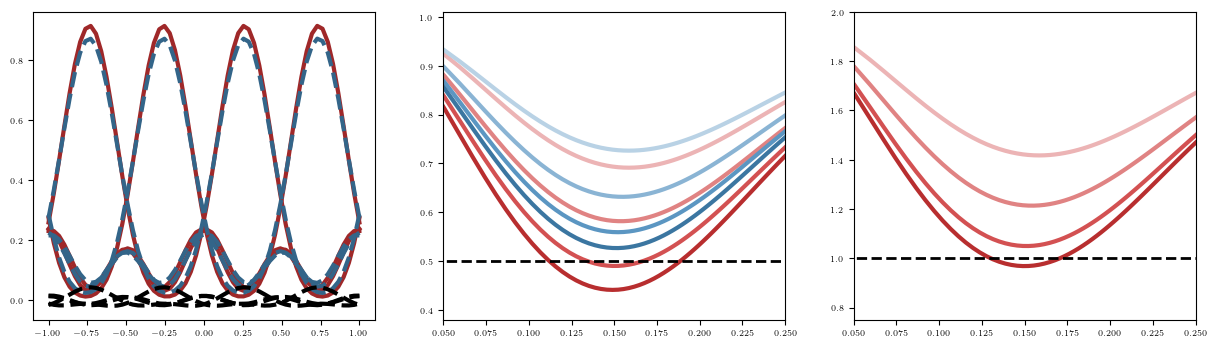

In [37]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
ax1, ax2, ax3 = axs

ax1.plot(vlist/l, p_array2, lw=3, color=red, label='TMSV',ls='-')
ax1.plot(vlist/l, p_array6, lw=3, color=blue, label='TMSV',ls='--')

for i in range(4):
    ax1.plot(vlist/l, p_array2[:,i]-p_array6[:,i], lw=3, color='black', label='TMSV',ls='--')

MSEDsq = [MSD_array1,MSD_array2, MSD_array3,MSD_array4]
for i in range(4):
    MSE = np.sum(MSEDsq[i], axis=1)
    ax2.plot(np.sqrt(variance_list)/l, MSE/variance_list, lw=3, color=lighten_color(red,.3+.2*i), label='TMSV',ls='-')
MSEDsp = [MSD_array5, MSD_array6, MSD_array7, MSD_array8]
for i in range(4):
    MSE = np.sum(MSEDsp[i], axis=1)
    ax2.plot(np.sqrt(variance_list)/l, MSE/variance_list, lw=3, color=lighten_color(blue,.3+.2*i), label='TMSV',ls='-')

for i in range(4):
    MSEq = np.sum(MSEDsq[i], axis=1)
    MSEp = np.sum(MSEDsp[i], axis=1)
    MSE = MSEq + MSEp
    ax3.plot(np.sqrt(variance_list)/l, MSE/variance_list, lw=3, color=lighten_color(red,.3+.2*i), label='TMSV',ls='-')


ax3.plot([0,1],[1.0,1.0],color='black',ls='--',lw=2)
ax2.plot([0,1],[.5,.5],color='black',ls='--',lw=2)

ax2.set_ylim(.38,1.01)
ax2.set_xlim(.05,.25)
ax3.set_ylim(.75,2)
ax3.set_xlim(.05,.25)

### checking different p0, q0

In [ ]:
#definitions of the parameters (q bits)
#1-3, delta = 0.3, yale, 1, 2, 8 rounds, p0=0
#4-6, delta = 0.3, yale, 1, 2, 8 rounds, p0=l/4
#7-9, delta = 0.3, yale, 1, 2, 8 rounds, q0=0
#10-12, delta = 0.3, yale, 1, 2, 8 rounds, q0=l/4
#13-14, delta = 0.3, yale, 4 rounds, q0=0, p0=0
#15-16, delta = 0.3, yale, 4 rounds, q0=l/4, p0=l/4
#17-19, delta = 0.3, 0.5 yale, 1,2,4 rounds, p0=l/4
#20-22, delta = 0.3, 0.5 yale, 1,2,4 rounds, q0=l/4
#23-24, delta = 0.3, 1.0, 0.5 yale, 8 rounds, p0=0
#25-27, delta = 0.25, yale, 1, 2, 4 rounds, p0=0
#28-30, delta = 0.25, 0.5 yale, 1, 2, 4 rounds, p0=0
#31-46, delta in (.25,.4,.01), yale, 1, round p0=0
#48-63, delta in (.25,.4,.01), 0.5 yale, 1, round p0=0
#64-79, delta in (.25,.4,.01), 0.75 yale, 1, round p0=0
#80-95, delta in (.25,.4,.01), 1.5 yale, 1, round p0=0
#96-99, delta = 0.34, yale, 1, 2, 4, 8 rounds, p0=0
#100-103, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, p0=0
#104-107, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, p0=0
#108-111, delta = 0.34, 0.75 yale, 1, 2, 4, 8 rounds, p0=0
#112-115, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, p0=0
#116-119, delta = 0.3,  yale, 1, 2, 4, 8 rounds, p0=0, sensitivity
#120-123, delta = 0.3, 0.5 yale, 1, 2, 4, 8 rounds, sensitivity
#124-127, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, sensitivity
#128-131, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, sensitivity
#132-135, delta = 0.3, 0.25 yale, 1, 2, 4, 8 rounds, sensitivity
#136-138, delta = 0.3, .5,1,1.5 yale, 4 rounds, sensitivity with p0=l/4


name1 = 'Data - qbits - params'+str(7)
results1 = np.load(path_QS_noise_results_qorppath+name1+'.npz')
print(results1.files)
vlist = results1['vlist']
p_array1 = results1['p_array']
MSD_array1 = results1['MSD_array']
variance_list = results1['variance_list']

name2 = 'Data - qbits - params'+str(8)
results2 = np.load(path_QS_noise_results_qorppath+name2+'.npz')
p_array2 = results2['p_array']
MSD_array2 = results2['MSD_array']

name3 = 'Data - qbits - params'+str(9)
results3 = np.load(path_QS_noise_results_qorppath+name3+'.npz')
p_array3 = results3['p_array']
MSD_array3 = results3['MSD_array']

name4 = 'Data - qbits - params'+str(10)
results4 = np.load(path_QS_noise_results_qorppath+name4+'.npz')
p_array4 = results4['p_array']
MSD_array4 = results4['MSD_array']

name5 = 'Data - qbits - params'+str(11)
results5 = np.load(path_QS_noise_results_qorppath+name5+'.npz')
p_array5 = results5['p_array']
MSD_array5 = results5['MSD_array']

name6 = 'Data - qbits - params'+str(3)
results6 = np.load(path_QS_noise_results_qorppath+name6+'.npz')
p_array6 = results6['p_array']
MSD_array6 = results6['MSD_array']

print(MSD_array1.shape,MSD_array2.shape,MSD_array3.shape, MSD_array4.shape, MSD_array5.shape)

['MSD_array', 'MSD_array_displacement', 'variance_list', 'p_array', 'vlist', 'rho0_c', 'system_dict', 'rho_f_array']
(101, 60) (101, 60) (101, 60) (101, 60) (101, 60)


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_9821/780577900.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(1,2, figsize=(10,4))


(0.4, 1.0)

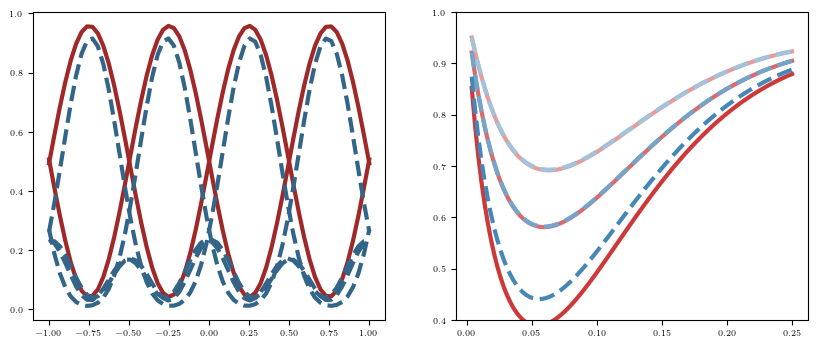

In [19]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax1, ax2 = axs
ax1.plot(vlist/l, p_array1, lw=3, color=red, label='TMSV',ls='-')
ax1.plot(vlist/l, p_array2, lw=3, color=blue, label='TMSV',ls='--')

MSEDs = [MSD_array1,MSD_array2, MSD_array3]
for i in range(3):
    MSE = np.sum(MSEDs[i], axis=1)
    ax2.plot(variance_list/l, MSE/variance_list, lw=3, color=lighten_color(red,.4+.2*i), label='TMSV',ls='-')
MSEDs = [MSD_array4,MSD_array5, MSD_array6]
for i in range(3):
    MSE = np.sum(MSEDs[i], axis=1)
    ax2.plot(variance_list/l, MSE/variance_list, lw=3, color=lighten_color(blue,.4+.2*i), label='TMSV',ls='--')

ax2.set_ylim(.4,1)

### comparing with full map

In [ ]:
#definitions of the parameters (q bits)
#1-3, delta = 0.3, yale, 1, 2, 8 rounds, p0=0
#4-6, delta = 0.3, yale, 1, 2, 8 rounds, p0=l/4
#7-9, delta = 0.3, yale, 1, 2, 8 rounds, q0=0
#10-12, delta = 0.3, yale, 1, 2, 8 rounds, q0=l/4
#13-14, delta = 0.3, yale, 4 rounds, q0=0, p0=0
#15-16, delta = 0.3, yale, 4 rounds, q0=l/4, p0=l/4
#17-19, delta = 0.3, 0.5 yale, 1,2,4 rounds, p0=l/4
#20-22, delta = 0.3, 0.5 yale, 1,2,4 rounds, q0=l/4
#23-24, delta = 0.3, 1.0, 0.5 yale, 8 rounds, p0=0
#25-27, delta = 0.25, yale, 1, 2, 4 rounds, p0=0
#28-30, delta = 0.25, 0.5 yale, 1, 2, 4 rounds, p0=0
#31-46, delta in (.25,.4,.01), yale, 1, round p0=0
#48-63, delta in (.25,.4,.01), 0.5 yale, 1, round p0=0
#64-79, delta in (.25,.4,.01), 0.75 yale, 1, round p0=0

#changing time of conditional displacement
#120-121, delta=0.25, noiseless, 1, 2 rounds, p0=0., TECD =0.5 
#122-124, delta=0.25, yale, 1, 2, 4 rounds, p0=0, TECD = 0.5
#125-127, delta=0.25, yale *1.5, 1, 2, 4 rounds, p0=0, TECD = 0.5
#128-130, delta=0.25, yale *0.5, 1, 2, 4 rounds, p0=0, TECD = 0.75
#134-136, delta=0.3, yale, 1, 2, 4 rounds, p0=0, TECD = 0.5
#137-139, delta=0.3, yale *1.5, 1, 2, 4 rounds, p0=0, TECD = 0.5
#140-142, delta=0.3, yale *0.5, 1, 2, 4 rounds, p0=0, TECD = 0.75


name1 = 'Data - qbits - params'+str(1)
results1 = np.load(path_QS_noise_results_qorppath+name1+'.npz')
print(results1.files)
vlist = results1['vlist']
p_array1 = results1['p_array']
MSD_array1 = results1['MSD_array']
variance_list = results1['variance_list']

name2 = 'Data - qbits - params'+str(2)
results2 = np.load(path_QS_noise_results_qorppath+name2+'.npz')
p_array2 = results2['p_array']
MSD_array2 = results2['MSD_array']

name3 = 'Data - qbits - params'+str(13)
results3 = np.load(path_QS_noise_results_qorppath+name3+'.npz')
p_array3 = results3['p_array']
MSD_array3 = results3['MSD_array']

name4 = 'Data - MSD - params'+str(134)
results4 = np.load(path_sbs_noise_results+name4+'.npz')
vlist4 = results4['vlist']
MSD_array4 = results4['MSD_array']

name5 = 'Data - MSD - params'+str(135)
results5 = np.load(path_sbs_noise_results+name5+'.npz')
MSD_array5 = results5['MSD_array']

name6 = 'Data - MSD - params'+str(136)
results6 = np.load(path_sbs_noise_results+name6+'.npz')
MSD_array6 = results6['MSD_array']

['MSD_array', 'MSD_array_displacement', 'variance_list', 'p_array', 'qf_array', 'pf_array', 'vlist', 'rho0_c', 'system_dict', 'rho_f_array']


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_5850/780577900.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(1,2, figsize=(10,4))


(0.4, 1.0)

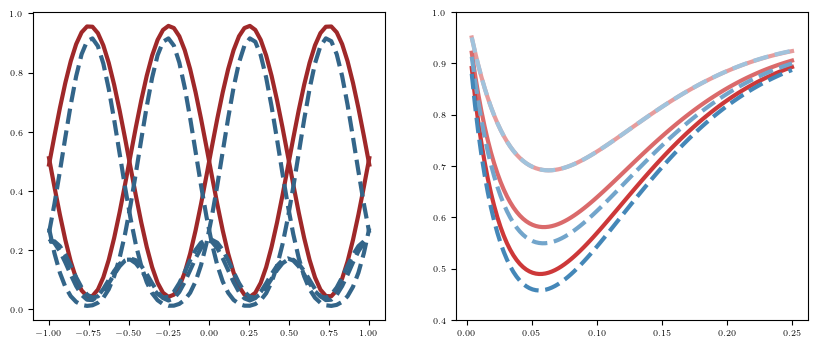

In [27]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax1, ax2 = axs
ax1.plot(vlist/l, p_array1, lw=3, color=red, label='TMSV',ls='-')
ax1.plot(vlist/l, p_array2, lw=3, color=blue, label='TMSV',ls='--')

MSEDs = [MSD_array1,MSD_array2, MSD_array3]
for i in range(3):
    MSE = np.sum(MSEDs[i], axis=1)
    ax2.plot(variance_list/l, MSE/variance_list, lw=3, color=lighten_color(red,.4+.2*i), label='TMSV',ls='-')
MSEDs = [MSD_array4,MSD_array5, MSD_array6]
for i in range(3):
    MSE = np.sum(MSEDs[i], axis=1)
    ax2.plot(variance_list/l, MSE/variance_list, lw=3, color=lighten_color(blue,.4+.2*i), label='TMSV',ls='--')

ax2.set_ylim(.4,1)

### comparing $\Delta (0.25,0.4,.01)$

In [ ]:
#definitions of the parameters (all bits)
#changing time of conditional displacement #these are the correct ones
#120-121, delta=0.25, noiseless, 1, 2 rounds, p0=0., TECD =0.5 
#122-124, delta=0.25, yale, 1, 2, 4 rounds, p0=0, TECD = 0.5
#125-127, delta=0.25, yale *1.5, 1, 2, 4 rounds, p0=0, TECD = 0.5
#128-130, delta=0.25, yale *0.5, 1, 2, 4 rounds, p0=0, TECD = 0.75
#134-136, delta=0.3, yale, 1, 2, 4 rounds, p0=0, TECD = 0.5
#137-139, delta=0.3, yale *1.5, 1, 2, 4 rounds, p0=0, TECD = 0.5
#140-142, delta=0.3, yale *0.5, 1, 2, 4 rounds, p0=0, TECD = 0.75

#definitions of the parameters (q bits)
#1-3, delta = 0.3, yale, 1, 2, 8 rounds, p0=0
#4-6, delta = 0.3, yale, 1, 2, 8 rounds, p0=l/4
#7-9, delta = 0.3, yale, 1, 2, 8 rounds, q0=0
#10-12, delta = 0.3, yale, 1, 2, 8 rounds, q0=l/4
#13-14, delta = 0.3, yale, 4 rounds, q0=0, p0=0
#15-16, delta = 0.3, yale, 4 rounds, q0=l/4, p0=l/4
#17-19, delta = 0.3, 0.5 yale, 1,2,4 rounds, p0=l/4
#20-22, delta = 0.3, 0.5 yale, 1,2,4 rounds, q0=l/4
#23-24, delta = 0.3, 1.0, 0.5 yale, 8 rounds, p0=0
#25-27, delta = 0.25, yale, 1, 2, 4 rounds, p0=0
#28-30, delta = 0.25, 0.5 yale, 1, 2, 4 rounds, p0=0
#31-46, delta in (.25,.4,.01), yale, 1, round p0=0
#48-63, delta in (.25,.4,.01), 0.5 yale, 1, round p0=0
#64-79, delta in (.25,.4,.01), 0.75 yale, 1, round p0=0
#80-95, delta in (.25,.4,.01), 1.5 yale, 1, round p0=0
#96-99, delta = 0.34, yale, 1, 2, 4, 8 rounds, p0=0

# 1 round all delta, forgotten 2.0, 0.25
#212-227, delta in (.25,.4,.01), 2.0 yale, 1, round p0=0
#228-243, delta in (.25,.4,.01), 0.25 yale, 1, round p0=0


MSD_arrays = []
MSD_mins_1, MSD_mins_05, MSD_mins_025, MSD_mins_2 = [], [], [], []

for idx in np.arange(228,244,1):
    name1 = 'Data - qbits - params'+str(idx)
    results1 = np.load(path_QS_noise_results_qorppath+name1+'.npz')
    variance_list = results1['variance_list']
    vlist = results1['vlist']
    MSD_arrays.append(results1['MSD_array'])
    MSE = np.sum(results1['MSD_array'], axis=1)
    MSD_mins_025.append(np.min(MSE/variance_list))

for idx in np.arange(48,64,1):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz')
    variance_list = results['variance_list']
    vlist = results['vlist']
    MSD_arrays.append(results['MSD_array'])
    MSE = np.sum(results['MSD_array'], axis=1)
    MSD_mins_05.append(np.min(MSE/variance_list))

for idx in np.arange(31,47,1):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz')
    variance_list = results['variance_list']
    vlist = results['vlist']
    MSD_arrays.append(results['MSD_array'])
    MSE = np.sum(results['MSD_array'], axis=1)
    MSD_mins_1.append(np.min(MSE/variance_list))

for idx in np.arange(212,228,1):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz')
    variance_list = results['variance_list']
    vlist = results['vlist']
    MSD_arrays.append(results['MSD_array'])
    MSE = np.sum(results['MSD_array'], axis=1)
    MSD_mins_2.append(np.min(MSE/variance_list))

min delta 0.31000000000000005 0.3400000000000001 0.3600000000000001 0.3800000000000001


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_38231/789450402.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax2 = plt.subplots(1,1, figsize=(5,4))


(0.25, 0.4)

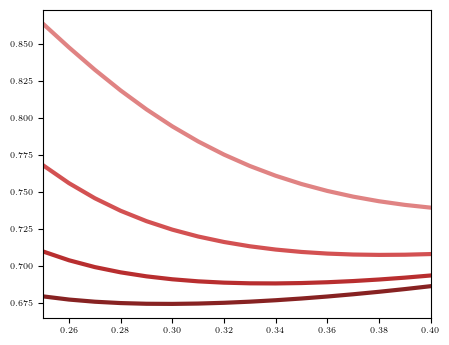

In [35]:
fig, ax2 = plt.subplots(1,1, figsize=(5,4))

delta_range = np.arange(.25,.41,.01)

ax2.plot(delta_range, MSD_mins_025, lw=3, color=lighten_color(red,.5), label='TMSV',ls='-')
ax2.plot(delta_range, MSD_mins_05, lw=3, color=lighten_color(red,.7), label='TMSV',ls='-')
ax2.plot(delta_range, MSD_mins_1, lw=3, color=lighten_color(red,.9), label='TMSV',ls='-')
ax2.plot(delta_range, MSD_mins_2, lw=3, color=lighten_color(red,1.1), label='TMSV',ls='-')

# ax2.plot([0,1],[.5,.5],color='black',ls='--',lw=2)

print('min delta', delta_range[np.argmin(MSD_mins15)] ,delta_range[np.argmin(MSD_mins_1)], delta_range[np.argmin(MSD_mins075)], delta_range[np.argmin(MSD_mins_05)])

dict_figure = {}
dict_figure['MSE_mins_025'] = MSD_mins_025
dict_figure['MSE_mins_05'] = MSD_mins_05
dict_figure['MSE_mins_1'] = MSD_mins_1
dict_figure['MSE_mins_2'] = MSD_mins_2
dict_figure['delta_range'] = delta_range
name = 'data-figure-min-MSE-noise-1-round'
np.savez(path_figures_data+name+'.npz', **dict_figure)

# ax2.set_ylim(.38,1.01)
ax2.set_xlim(.25,.40)

### Yale noise level comparison different $\Delta$

In [ ]:
#definitions of the parameters (all bits)
#changing time of conditional displacement #these are the correct ones
#120-121, delta=0.25, noiseless, 1, 2 rounds, p0=0., TECD =0.5 
#122-124, delta=0.25, yale, 1, 2, 4 rounds, p0=0, TECD = 0.5
#125-127, delta=0.25, yale *1.5, 1, 2, 4 rounds, p0=0, TECD = 0.5
#128-130, delta=0.25, yale *0.5, 1, 2, 4 rounds, p0=0, TECD = 0.75
#134-136, delta=0.3, yale, 1, 2, 4 rounds, p0=0, TECD = 0.5
#137-139, delta=0.3, yale *1.5, 1, 2, 4 rounds, p0=0, TECD = 0.5
#140-142, delta=0.3, yale *0.5, 1, 2, 4 rounds, p0=0, TECD = 0.75

#definitions of the parameters (q bits)
#1-3, delta = 0.3, yale, 1, 2, 8 rounds, p0=0
#4-6, delta = 0.3, yale, 1, 2, 8 rounds, p0=l/4
#7-9, delta = 0.3, yale, 1, 2, 8 rounds, q0=0
#10-12, delta = 0.3, yale, 1, 2, 8 rounds, q0=l/4
#13-14, delta = 0.3, yale, 4 rounds, q0=0, p0=0
#15-16, delta = 0.3, yale, 4 rounds, q0=l/4, p0=l/4
#17-19, delta = 0.3, 0.5 yale, 1,2,4 rounds, p0=l/4
#20-22, delta = 0.3, 0.5 yale, 1,2,4 rounds, q0=l/4
#23-24, delta = 0.3, 1.0, 0.5 yale, 8 rounds, p0=0
#25-27, delta = 0.25, yale, 1, 2, 4 rounds, p0=0
#28-30, delta = 0.25, 0.5 yale, 1, 2, 4 rounds, p0=0
#31-46, delta in (.25,.4,.01), yale, 1, round p0=0
#48-63, delta in (.25,.4,.01), 0.5 yale, 1, round p0=0
#64-79, delta in (.25,.4,.01), 0.75 yale, 1, round p0=0
#80-95, delta in (.25,.4,.01), 1.5 yale, 1, round p0=0
#96-99, delta = 0.34, yale, 1, 2, 4, 8 rounds, p0=0

MSE_arrays_30, MSE_arrays_34 = [], []

for idx in [1,2,13,3]:
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz')
    variance_list = results['variance_list']
    vlist = results['vlist']
    MSE = np.sum(results['MSD_array'], axis=1)
    MSE_arrays_30.append(MSE)

for idx in np.arange(96,100,1):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz')
    variance_list = results['variance_list']
    vlist = results['vlist']
    MSE = np.sum(results['MSD_array'], axis=1)
    MSE_arrays_34.append(MSE)

/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_38231/558622983.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(5,4))


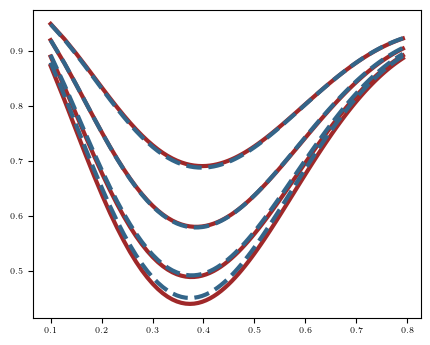

In [116]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

stddev_list = np.sqrt(variance_list)

for i in range(4):
    ax.plot(stddev_list, MSE_arrays_30[i]/variance_list, lw=3, color=red, label='None',ls='-')
    ax.plot(stddev_list, MSE_arrays_34[i]/variance_list, lw=3, color=blue, label='None',ls='--')

# # ax2.set_ylim(.38,1.01)
# ax2.set_xlim(.25,.40)

### q vs p

In [ ]:
#q or p path
# 203-205, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0
# 206-208, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.25l
# 209-211, delta = 0.3, 1.0 yale, 1,2,4 rounds, q0=0

# in exact
# runs for test purposes
#200-202, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.15l
# 203-205, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0
# 206-208, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.25l
# 209-211, delta = 0.3, 1.0 yale, 1,2,4 rounds, q0=0


# test, in exact
# 1 delta = 0.3, 1 round, p0=0
# 2 delta = 0.3, 1 round, q0=0
# isolating each noise, up to 4 bits per quadrature

MSE_q, MSE_p = [], []
MSE_qexact, MSE_pexact = [], []

for idx in np.arange(203,206):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz')
    variance_list = results['variance_list']
    vlist = results['vlist']
    MSE = np.sum(results['MSD_array'], axis=1)
    MSE_q.append(MSE)

for idx in np.arange(209,212):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz')
    variance_list = results['variance_list']
    vlist = results['vlist']
    MSE = np.sum(results['MSD_array'], axis=1)
    MSE_p.append(MSE)

for idx in np.arange(203,206):
    name = 'Data - MSD - params'+str(idx)
    results = np.load(path_sbs_noise_results_exact+name+'.npz')
    variance_list = results['variance_list']
    vlist = results['vlist']
    MSE = np.sum(results['MSD_array'], axis=1)
    MSE_qexact.append(MSE)
for idx in np.arange(209,212):
    name = 'Data - MSD - params'+str(idx)
    results = np.load(path_sbs_noise_results_exact+name+'.npz')
    variance_list = results['variance_list']
    vlist = results['vlist']
    MSE = np.sum(results['MSD_array'], axis=1)
    MSE_pexact.append(MSE)

min ratio 0 0.6913368840483882 0.691331800916949
min ratio 1 0.5808504724548393 0.5808129788740797
min ratio 2 0.4894454964223438 0.48941110182127817


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_38231/1857756903.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(5,4))


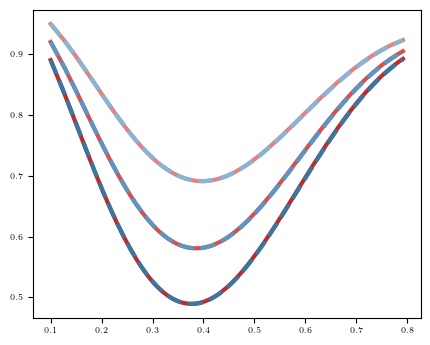

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(5,4))

stddev_list = np.sqrt(variance_list)

for i in range(3):
    print('min ratio', i, np.min(MSE_q[i]/variance_list), np.min(MSE_p[i]/variance_list))
    shine = .5+.2*i 
    ax.plot(stddev_list, MSE_qexact[i]/variance_list, lw=3, color=lighten_color(red,shine), label='None',ls='-')
    ax.plot(stddev_list, MSE_pexact[i]/variance_list, lw=3, color=lighten_color(blue,shine), label='None',ls='--')

### different noise $\Delta = 0.3$

In [ ]:
#definitions of the parameters (all bits)
#changing time of conditional displacement #these are the correct ones
#120-121, delta=0.25, noiseless, 1, 2 rounds, p0=0., TECD =0.5 
#122-124, delta=0.25, yale, 1, 2, 4 rounds, p0=0, TECD = 0.5
#125-127, delta=0.25, yale *1.5, 1, 2, 4 rounds, p0=0, TECD = 0.5
#128-130, delta=0.25, yale *0.5, 1, 2, 4 rounds, p0=0, TECD = 0.75
#134-136, delta=0.3, yale, 1, 2, 4 rounds, p0=0, TECD = 0.5
#137-139, delta=0.3, yale *1.5, 1, 2, 4 rounds, p0=0, TECD = 0.5
#140-142, delta=0.3, yale *0.5, 1, 2, 4 rounds, p0=0, TECD = 0.75

#definitions of the parameters (q bits)
#1-3, delta = 0.3, yale, 1, 2, 8 rounds, p0=0
#4-6, delta = 0.3, yale, 1, 2, 8 rounds, p0=l/4
#7-9, delta = 0.3, yale, 1, 2, 8 rounds, q0=0
#10-12, delta = 0.3, yale, 1, 2, 8 rounds, q0=l/4
#13-14, delta = 0.3, yale, 4 rounds, q0=0, p0=0
#15-16, delta = 0.3, yale, 4 rounds, q0=l/4, p0=l/4
#17-19, delta = 0.3, 0.5 yale, 1,2,4 rounds, p0=l/4
#20-22, delta = 0.3, 0.5 yale, 1,2,4 rounds, q0=l/4
#23-24, delta = 0.3, 1.0, 0.5 yale, 8 rounds, p0=0
#25-27, delta = 0.25, yale, 1, 2, 4 rounds, p0=0
#28-30, delta = 0.25, 0.5 yale, 1, 2, 4 rounds, p0=0
#31-46, delta in (.25,.4,.01), yale, 1, round p0=0
#48-63, delta in (.25,.4,.01), 0.5 yale, 1, round p0=0
#64-79, delta in (.25,.4,.01), 0.75 yale, 1, round p0=0
#80-95, delta in (.25,.4,.01), 1.5 yale, 1, round p0=0
#96-99, delta = 0.34, yale, 1, 2, 4, 8 rounds, p0=0
#100-103, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, p0=0
#104-107, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, p0=0
#108-111, delta = 0.34, 0.75 yale, 1, 2, 4, 8 rounds, p0=0
#112-115, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, p0=0
#116-119, delta = 0.3,  yale, 1, 2, 4, 8 rounds, p0=0, sensitivity
#120-123, delta = 0.3, 0.5 yale, 1, 2, 4, 8 rounds, sensitivity
#124-127, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, sensitivity
#128-131, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, sensitivity
#132-135, delta = 0.3, 0.25 yale, 1, 2, 4, 8 rounds, sensitivity
#136-138, delta = 0.3, .5,1,1.5 yale, 4 rounds, sensitivity with p0=l/4
#139-142, delta = 0.3, 1 yale, 1,2,4,8 rounds, sensitivity with q0=0 p quadrature runs
#143-146, delta = 0.3, 2.0 yale, 1, 2, 4, 8 rounds, 
#147-150, delta = 0.3, 2.0 yale, 1, 2, 4, 8 rounds, sensitivity with p0=0
#151-152, delta = 0.3, 1.0 yale, 8 rounds, p0=0, q0=0 #use these results for backaction evading inputs
#153, delta = 0.3, 1.0 yale, 2 rounds, q0 = 0
#154-157, delta = 0.3, 0.25 yale, 1,2,4,8 rounds, p0 = 0
#158-161, delta = 0.3, 0.25 yale, 1,2,4,8 rounds, sensitivity

MSE_arrays_30, MSE_arrays_34 = [], []

for idx in [146,151,24, 157]:
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz')
    variance_list = results['variance_list']
    vlist = results['vlist']
    MSE = np.sum(results['MSD_array'], axis=1)
    MSE_arrays_30.append(MSE)

for idx in np.arange(100,104,1):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz')
    variance_list = results['variance_list']
    vlist = results['vlist']
    MSE = np.sum(results['MSD_array'], axis=1)
    MSE_arrays_34.append(MSE)

/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_10826/3156334488.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(5,4))


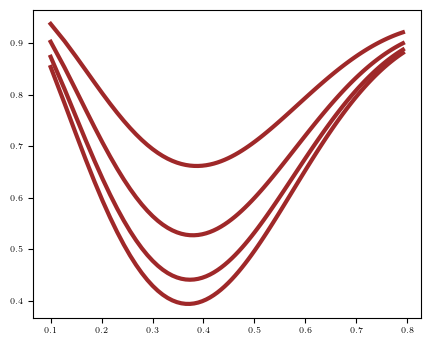

In [26]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

stddev_list = np.sqrt(variance_list)

for i in range(4):
    ax.plot(stddev_list, MSE_arrays_30[i]/variance_list, lw=3, color=red, label='None',ls='-')
    # ax.plot(stddev_list, MSE_arrays_34[i]/variance_list, lw=3, color=blue, label='None',ls='-')

# # ax2.set_ylim(.38,1.01)
# ax2.set_xlim(.25,.40)

## sensitivity

### simple check

In [ ]:
#definitions of the parameters (q bits)
#116-119, delta = 0.3,  yale, 1, 2, 4, 8 rounds, p0=0, sensitivity
#120-123, delta = 0.3, 0.5 yale, 1, 2, 4, 8 rounds, sensitivity
#124-127, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, sensitivity
#128-131, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, sensitivity

MSE_arrays = []
sensitivities = []
vlist = np.linspace(-.25*l, .25*l, 60)
for idx in tqdm([131,119,123,127]):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    MSE_arrays.append(MSE)
    sensitivities.append(sensitivity)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:13<00:00,  3.28s/it]


(0.05, 0.25)

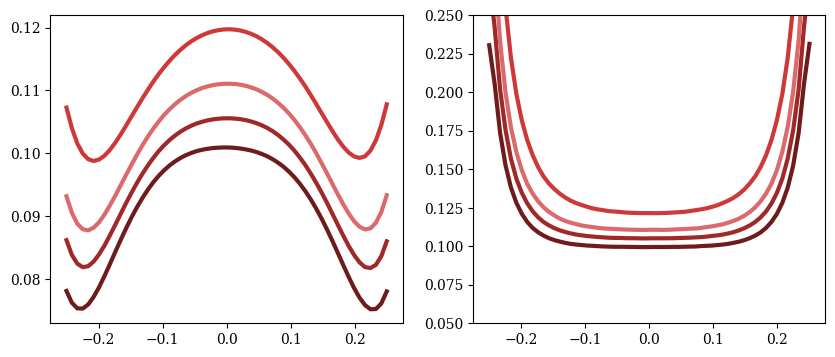

In [5]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax1, ax2 = axs

for i in range(4):
    ax1.plot(vlist/l, np.sqrt(MSE_arrays[i])/l, lw=3, color=lighten_color(red,1.2-.2*i), label='None',ls='-')
    ax2.plot(vlist/l, sensitivities[i]/l, lw=3, color=lighten_color(red,1.2-.2*i), label='None',ls='-')
ax2.set_ylim(0.05,.25)

### q vs p, yale noise, 8 rounds

In [ ]:
#116-119, delta = 0.3,  yale, 1, 2, 4, 8 rounds, p0=0, sensitivity
#120-123, delta = 0.3, 0.5 yale, 1, 2, 4, 8 rounds, sensitivity
#124-127, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, sensitivity
#128-131, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, sensitivity
#132-135, delta = 0.3, 0.25 yale, 1, 2, 4, 8 rounds, sensitivity
#136-138, delta = 0.3, .5,1,1.5 yale, 4 rounds, sensitivity with p0=l/4
#139-142, delta = 0.3, 1 yale, 1,2,4,8 rounds, sensitivity with q0=0 p quadrature runs
#260-263, delta = 0.3, 1.0 yale, 1, 2, 4, 8 rounds, sensitivity with q0=0

#running noise up to 4 bits per quadrature
#268-270, delta = 0.3, 0.25 yale, 1,2,4 rounds, q0=0 sensitivity
#271-273, delta = 0.3, 0.25 yale, 1,2,4 rounds, p0=0 sensitivity

# start from ideal state and have noisy metrology
#274-276, delta = 0.3, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity

sensitivities_q, sensitivities_p = [], []
vlist = np.linspace(-.25*l, .25*l, 60)
for idx in tqdm(np.arange(271,274)):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    vlist = results['vlist']
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_p.append(sensitivity)

for idx in tqdm(np.arange(268,271)):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_q.append(sensitivity)

100%|██████████| 3/3 [00:00<00:00, 148.16it/s]


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_38231/2066283484.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(4,3))


(0.05, 0.25)

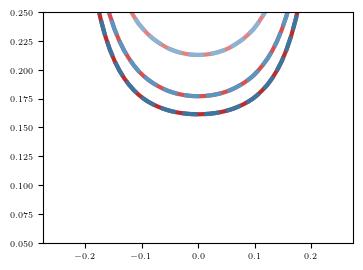

In [154]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

for i in range(3):
    shine = .5+.2*i
    ax.plot(vlist/l, sensitivities_q[i]/l, lw=3, color=lighten_color(red,shine), label='q quadrature',ls='-')
    ax.plot(vlist/l, sensitivities_q[i]/l, lw=3, color=lighten_color(blue,shine), label='q quadrature',ls='--')

ax.set_ylim(0.05,.25)

## Sensitivity, 4 Delta, 4 noise levels, 4 rounds

In [ ]:
#sensitivites with 4 deltas, 4 noise levels, and 4 rounds
#244-247, delta = 0.25, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity
#248-251, delta = 0.30, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity
#252-255, delta = 0.35, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity
#256-259, delta = 0.40, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity

sensitivities_25, sensitivities_30, sensitivities_35, sensitivities_40 = [], [], [], []
min_sensitivities_25, min_sensitivities_30, min_sensitivities_35, min_sensitivities_40 = [], [], [], []
vlist = np.linspace(-.25*l, .25*l, 60)
for idx in tqdm(np.arange(244,248)):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_25.append(sensitivity)
    min_sensitivities_25.append(np.min(sensitivity))

for idx in tqdm(np.arange(248,252)):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_30.append(sensitivity)
    min_sensitivities_30.append(np.min(sensitivity))

for idx in tqdm(np.arange(252,256)):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_35.append(sensitivity)
    min_sensitivities_35.append(np.min(sensitivity))

for idx in tqdm(np.arange(256,260)):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_40.append(sensitivity)
    min_sensitivities_40.append(np.min(sensitivity))

100%|██████████| 4/4 [00:00<00:00, 51.87it/s]


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_38231/633748423.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(4,2.5))


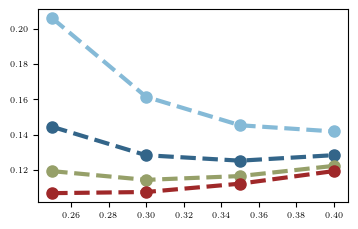

In [87]:
fig, ax = plt.subplots(1,1, figsize=(4,2.5))

ratios = [.25,.5,1.0,2.0]
delta_range = [.25,.30,.35,.40]

sensitivities_all = [min_sensitivities_25, min_sensitivities_30, min_sensitivities_35, min_sensitivities_40]

min_sens_025, min_sens_050, min_sens_1, min_sens_2 = [], [], [], []
for j in range(4):
    min_sens_025.append(sensitivities_all[j][0])
    min_sens_050.append(sensitivities_all[j][1])
    min_sens_1.append(sensitivities_all[j][2])
    min_sens_2.append(sensitivities_all[j][3])

# ax.plot(ratios,min_sensitivities_25/l, lw=3, color=lighten_color(light_blue,1),ls='-',marker='o', markersize=8, label=r'$\Delta=0.25$')
# ax.plot(ratios,min_sensitivities_30/l, lw=3, color=lighten_color(blue,1),ls='-',marker='o', markersize=8,label=r'$\Delta=0.30$')
# ax.plot(ratios,min_sensitivities_35/l, lw=3, color=lighten_color(green,1),ls='-',marker='o', markersize=8,label=r'$\Delta=0.35$')
# ax.plot(ratios,min_sensitivities_40/l, lw=3, color=lighten_color(red,1),ls='-',marker='o', markersize=8,label=r'$\Delta=0.40$')


ax.plot(delta_range, min_sens_025/l, lw=3, color=lighten_color(light_blue,1),ls='--',marker='o', markersize=8)
ax.plot(delta_range, min_sens_050/l, lw=3, color=lighten_color(blue,1),ls='--',marker='o', markersize=8)
ax.plot(delta_range, min_sens_1/l, lw=3, color=lighten_color(green,1),ls='--',marker='o', markersize=8)
ax.plot(delta_range, min_sens_2/l, lw=3, color=lighten_color(red,1),ls='--',marker='o', markersize=8)

dict_figure = {}
dict_figure['min_sensitivities_25'] = min_sensitivities_25
dict_figure['min_sensitivities_30'] = min_sensitivities_30
dict_figure['min_sensitivities_35'] = min_sensitivities_35
dict_figure['min_sensitivities_40'] = min_sensitivities_40
dict_figure['min_sens_025'] = min_sens_025
dict_figure['min_sens_050'] = min_sens_050
dict_figure['min_sens_1'] = min_sens_1
dict_figure['min_sens_2'] = min_sens_2
dict_figure['ratios'] = ratios
name = 'data-figure-min-sensitivities-noise-deltas'
np.savez(path_figures_data+name+'.npz', **dict_figure)

# ax.set_xlabel(r'$T/T_0$')
# ax.set_ylabel(r'sensitivity/l')
# ax.set_xticks(ratios)
# ax.set_xticklabels([r'$0.25$',r'$0.50$',r'$1.00$',r'$2.00$'])
# ax.legend(loc='upper right', fontsize=12,frameon=False)
#the state for Delta=0.3 and yale noise is wrong, fix it. 

## Plotting for the paper, Gaussian and sensitivity

In [ ]:
#definitions of the parameters (q bits)
#116-119, delta = 0.3,  yale, 1, 2, 4, 8 rounds, p0=0, sensitivity
#120-123, delta = 0.3, 0.5 yale, 1, 2, 4, 8 rounds, sensitivity
#124-127, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, sensitivity
#128-131, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, sensitivity
#158-161, delta = 0.3, 0.25 yale, 1,2,4,8 rounds, sensitivity

MSE_arrays = []
sensitivities = []
vlist = np.linspace(-.25*l, .25*l, 60)
for idx in tqdm([131,119,123,127,161]):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    MSE_arrays.append(MSE)
    sensitivities.append(sensitivity)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:20<00:00,  4.20s/it]


In [6]:
for i in range(5):
    print(np.min(sensitivities[i]/l))

0.09945227192599594
0.10510603874174733
0.12148980123480359
0.11064574831570219
0.15367146450998284


In [ ]:
#definitions of the parameters (q bits)
#1-3, delta = 0.3, yale, 1, 2, 8 rounds, p0=0
#4-6, delta = 0.3, yale, 1, 2, 8 rounds, p0=l/4
#7-9, delta = 0.3, yale, 1, 2, 8 rounds, q0=0
#10-12, delta = 0.3, yale, 1, 2, 8 rounds, q0=l/4
#13-14, delta = 0.3, yale, 4 rounds, q0=0, p0=0
#15-16, delta = 0.3, yale, 4 rounds, q0=l/4, p0=l/4
#17-19, delta = 0.3, 0.5 yale, 1,2,4 rounds, p0=l/4
#20-22, delta = 0.3, 0.5 yale, 1,2,4 rounds, q0=l/4
#23-24, delta = 0.3, 1.0, 0.5 yale, 8 rounds, p0=0
#25-27, delta = 0.25, yale, 1, 2, 4 rounds, p0=0
#28-30, delta = 0.25, 0.5 yale, 1, 2, 4 rounds, p0=0
#31-46, delta in (.25,.4,.01), yale, 1, round p0=0
#48-63, delta in (.25,.4,.01), 0.5 yale, 1, round p0=0
#64-79, delta in (.25,.4,.01), 0.75 yale, 1, round p0=0
#80-95, delta in (.25,.4,.01), 1.5 yale, 1, round p0=0
#96-99, delta = 0.34, yale, 1, 2, 4, 8 rounds, p0=0

MSE_arrays_30, MSE_arrays_34 = [], []

for idx in [1,2,13,3]:
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz')
    variance_list = results['variance_list']
    vlist = results['vlist']
    MSE = np.sum(results['MSD_array'], axis=1)
    MSE_arrays_30.append(MSE)

for idx in np.arange(96,100,1):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz')
    variance_list = results['variance_list']
    vlist = results['vlist']
    MSE = np.sum(results['MSD_array'], axis=1)
    MSE_arrays_34.append(MSE)

sensor n 5.260785275959938
QFI-r: 1.568684079583588 dB-QFI: 13.625416792252675 gain-QFI: 6.271634491302302


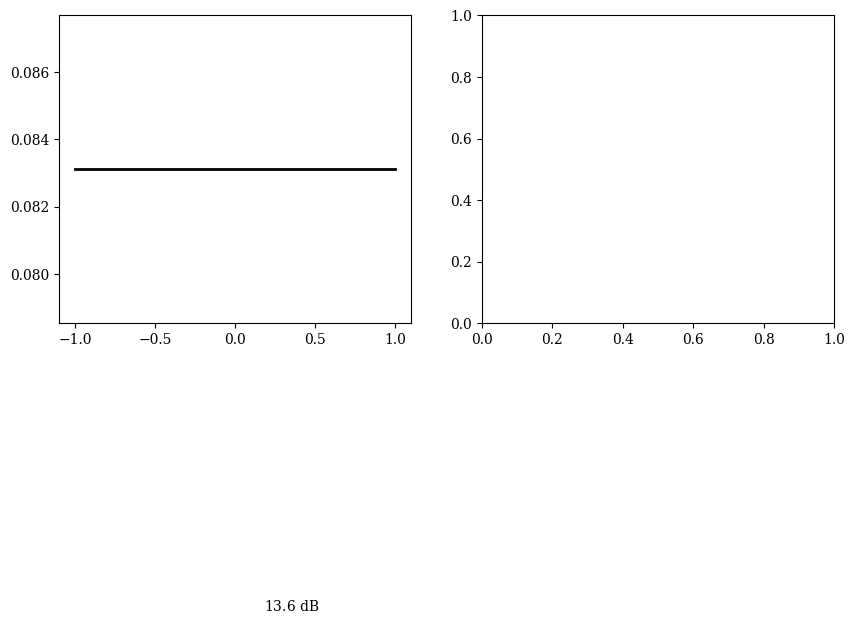

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax1, ax2 = axs
delta, N_c, r = 0.3, 140, 1.0
name = path_QS_noise_results_states + "coherent_sensor_state_delta_{}-Nc{}-{}.npz".format(int(100 * delta), N_c, r)
sensor_dict = np.load(name)
sensor = qt.Qobj(sensor_dict['rho_f_array'][0])
n_op = qt.num(N_c)
n = (n_op * sensor).tr()
QFI = np.real(1/(4*n+2))
print('sensor n',np.real(n))

ax1.plot([-1,1],[np.sqrt(QFI)/l,np.sqrt(QFI)/l],color=lighten_color('black',1),lw=2,ls='-',label=r'1/$\sqrt{\text{QFI}}$')
r_QFI = np.log(1/np.sqrt(QFI))
dB_QFI = 10*np.log10(np.exp(2*r_QFI))
gain_QFI = np.cosh(r_QFI)**2

ax1.text(0.18,.07,r'${0:.1f}$ dB'.format(dB_QFI),fontsize=10,color=lighten_color('black',1))

print('QFI-r:',np.real(r_QFI),'dB-QFI:',dB_QFI, 'gain-QFI:',gain_QFI)

## Estimators

### simple test

In [ ]:
name1 = 'Data - qbits - params'+str(1)
results1 = np.load(path_QS_noise_results_qorppath+name1+'.npz')
print(results1.files)
vlist = results1['vlist']
p_array1 = results1['p_array']

name2 = 'Data - qbits - params'+str(3)
results2 = np.load(path_QS_noise_results_qorppath+name2+'.npz')
vlist2 = results2['vlist']
p_array2 = results2['p_array']
qf_array2 = results2['qf_array']
pf_array2 = results2['pf_array']

['MSD_array', 'MSD_array_displacement', 'variance_list', 'p_array', 'qf_array', 'pf_array', 'vlist', 'rho0_c', 'system_dict', 'rho_f_array']


0.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [0.51087613 0.41347999 0.32002507 0.23476315 0.16157955 0.10380606
 0.06407577 0.0442156  0.04508662 0.066673   0.10799142 0.1671604
 0.24148619 0.32758462 0.42153433 0.51905745 0.61571325 0.70709988
 0.78905611 0.85785011 0.91034857 0.94416185 0.95775016 0.95049372
 0.92272274 0.87570261 0.81157333 0.73325669 0.64431799 0.54880726
 0.45107405 0.35556873 0.2666408  0.18833851 0.12422948 0.07723137
 0.04948495 0.04225441 0.0558666  0.08970424 0.14222435 0.21103631
 0.29300676 0.38440246 0.48106187 0.57858335 0.6725261  0.75861251
 0.83292158 0.89207048 0.93336576 0.95492727 0.95577274 0.93588743
 0.8961336  0.83833964 0.7651399  0.67986494 0.58640253 0.48900497]
0.5000172156411745 0.49998278417340686
posteriors 1.0 0.9999999999999999
(2, 60) 2


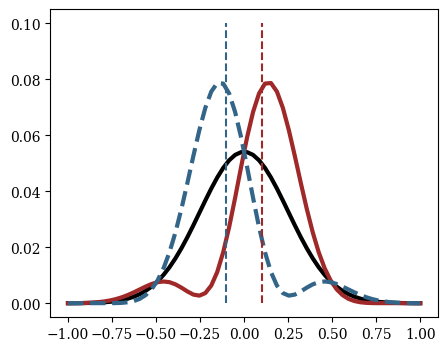

In [4]:
vlist = np.linspace(-l,l,60)
print(np.sum(vlist-vlist2))

p_bitstrings_q1 = np.transpose(p_array1)
print(np.sum(p_bitstrings_q1,axis=0), p_bitstrings_q1[1])

stddev = l/4
prior = np.exp(-vlist**2/(2*stddev**2))
prior = prior/np.sum(prior)
p_10 = np.sum(p_bitstrings_q1[0]*prior)
p_11 = np.sum(p_bitstrings_q1[1]*prior)
print(p_10, p_11)

posterior_10 = p_bitstrings_q1[0]*prior/p_10
posterior_11 = p_bitstrings_q1[1]*prior/p_11
print('posteriors',np.sum(posterior_10), np.sum(posterior_11))

estimators = estimators_from_parray(p_array1,vlist,stddev)
estimator_10 = estimators[0]
estimator_11 = estimators[1]

fig, ax = plt.subplots(1,1, figsize=(5,4))
ax.plot(vlist/l, prior, lw=3, color='black', label='prior')
ax.plot(vlist/l, posterior_10, lw=3, color=red, label='TMSV',ls='-')
ax.plot(vlist/l, posterior_11, lw=3, color=blue, label='TMSV',ls='--')
ax.plot([estimator_10/l,estimator_10/l],[0,.1],color=red,ls='--')
ax.plot([estimator_11/l,estimator_11/l],[0,.1],color=blue,ls='--')

### getting the estimators for backaction evading test

In [ ]:
#definitions of the parameters (q bits)
#1-3, delta = 0.3, yale, 1, 2, 8 rounds, p0=0
#4-6, delta = 0.3, yale, 1, 2, 8 rounds, p0=l/4
#7-9, delta = 0.3, yale, 1, 2, 8 rounds, q0=0
#10-12, delta = 0.3, yale, 1, 2, 8 rounds, q0=l/4
#13-14, delta = 0.3, yale, 4 rounds, q0=0, p0=0
#15-16, delta = 0.3, yale, 4 rounds, q0=l/4, p0=l/4
#17-19, delta = 0.3, 0.5 yale, 1,2,4 rounds, p0=l/4
#20-22, delta = 0.3, 0.5 yale, 1,2,4 rounds, q0=l/4
#23-24, delta = 0.3, 1.0, 0.5 yale, 8 rounds, p0=0
#25-27, delta = 0.25, yale, 1, 2, 4 rounds, p0=0
#28-30, delta = 0.25, 0.5 yale, 1, 2, 4 rounds, p0=0
#31-46, delta in (.25,.4,.01), yale, 1, round p0=0
#48-63, delta in (.25,.4,.01), 0.5 yale, 1, round p0=0
#64-79, delta in (.25,.4,.01), 0.75 yale, 1, round p0=0
#80-95, delta in (.25,.4,.01), 1.5 yale, 1, round p0=0
#96-99, delta = 0.34, yale, 1, 2, 4, 8 rounds, p0=0
#100-103, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, p0=0
#104-107, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, p0=0
#108-111, delta = 0.34, 0.75 yale, 1, 2, 4, 8 rounds, p0=0
#112-115, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, p0=0
#116-119, delta = 0.3,  yale, 1, 2, 4, 8 rounds, p0=0, sensitivity
#120-123, delta = 0.3, 0.5 yale, 1, 2, 4, 8 rounds, sensitivity
#124-127, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, sensitivity
#128-131, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, sensitivity
#132-135, delta = 0.3, 0.25 yale, 1, 2, 4, 8 rounds, sensitivity
#136-138, delta = 0.3, .5,1,1.5 yale, 4 rounds, sensitivity with p0=l/4
#139-142, delta = 0.3, 1 yale, 1,2,4,8 rounds, sensitivity with q0=0 p quadrature runs

name1 = 'Data - qbits - params'+str(151)
results1 = np.load(path_QS_noise_results_qorppath+name1+'.npz')
vlist1 = results1['vlist']
p_array1 = results1['p_array']

name2 = 'Data - qbits - params'+str(152)
results2 = np.load(path_QS_noise_results_qorppath+name2+'.npz')
vlist2 = results2['vlist']
p_array2 = results2['p_array']
qf_array2 = results2['qf_array']
pf_array2 = results2['pf_array']

stddev = 0.15*l

estimators_q = estimators_from_parray(p_array1,vlist1,stddev)
estimators_p = estimators_from_parray(p_array2,vlist2,stddev)# it takes no time no need to save them

print(p_array1.shape, p_array2.shape)

(256, 60) 256
(256, 60) 256
(60, 256) (60, 256)


## Tests

### testing q and p path versus exact, up to 4 bits per quadrature

### q path, different p0

In [ ]:
# runs for test purposes
# 200-202, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.15l
# 203-205, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0
# 206-208, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.25l

name1 = 'Data - qbits - params'+str(203)
results1 = np.load(path_QS_noise_results_qorppath+name1+'.npz')
print(results1.files)
vlist = results1['vlist']
p_array1 = results1['p_array']
MSD_array1 = results1['MSD_array']
variance_list = results1['variance_list']

name2 = 'Data - qbits - params'+str(204)
results2 = np.load(path_QS_noise_results_qorppath+name2+'.npz')
p_array2 = results2['p_array']
MSD_array2 = results2['MSD_array']

name3 = 'Data - qbits - params'+str(205)
results3 = np.load(path_QS_noise_results_qorppath+name3+'.npz')
p_array3 = results3['p_array']
MSD_array3 = results3['MSD_array']

name4 = 'Data - qbits - params'+str(200)
results4 = np.load(path_QS_noise_results_qorppath+name4+'.npz')
vlist4 = results4['vlist']
MSD_array4 = results4['MSD_array']

name5 = 'Data - qbits - params'+str(201)
results5 = np.load(path_QS_noise_results_qorppath+name5+'.npz')
MSD_array5 = results5['MSD_array']

name6 = 'Data - qbits - params'+str(202)
results6 = np.load(path_QS_noise_results_qorppath+name6+'.npz')
MSD_array6 = results6['MSD_array']

['MSD_array', 'MSD_array_displacement', 'variance_list', 'p_array', 'qf_array', 'pf_array', 'vlist', 'rho0_c', 'system_dict', 'rho_f_array']


(0.4, 1.0)

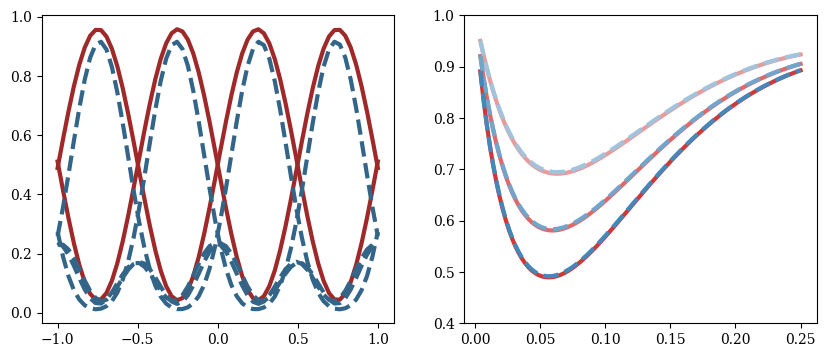

In [10]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax1, ax2 = axs
ax1.plot(vlist/l, p_array1, lw=3, color=red, label='TMSV',ls='-')
ax1.plot(vlist/l, p_array2, lw=3, color=blue, label='TMSV',ls='--')

MSEDs = [MSD_array1,MSD_array2, MSD_array3]
for i in range(3):
    MSE = np.sum(MSEDs[i], axis=1)
    ax2.plot(variance_list/l, MSE/variance_list, lw=3, color=lighten_color(red,.4+.2*i), label='TMSV',ls='-')
MSEDs = [MSD_array4,MSD_array5, MSD_array6]
for i in range(3):
    MSE = np.sum(MSEDs[i], axis=1)
    ax2.plot(variance_list/l, MSE/variance_list, lw=3, color=lighten_color(blue,.4+.2*i), label='TMSV',ls='--')

ax2.set_ylim(.4,1)

### qpath vs exact

In [ ]:
# runs for test purposes
# 200-202, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.15l
# 203-205, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0
# 206-208, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.25l

name1 = 'Data - qbits - params'+str(206)
results1 = np.load(path_QS_noise_results_qorppath+name1+'.npz')
print(results1.files)
vlist = results1['vlist']
p_array1 = results1['p_array']
MSD_array1 = results1['MSD_array']
variance_list = results1['variance_list']

name2 = 'Data - qbits - params'+str(207)
results2 = np.load(path_QS_noise_results_qorppath+name2+'.npz')
p_array2 = results2['p_array']
MSD_array2 = results2['MSD_array']

name3 = 'Data - qbits - params'+str(208)
results3 = np.load(path_QS_noise_results_qorppath+name3+'.npz')
p_array3 = results3['p_array']
MSD_array3 = results3['MSD_array']

name4 = 'Data - MSD - params'+str(206)
results4 = np.load(path_sbs_noise_results_exact+name4+'.npz')
vlist4 = results4['vlist']
MSD_array4 = results4['MSD_array']

name5 = 'Data - MSD - params'+str(207)
results5 = np.load(path_sbs_noise_results_exact+name5+'.npz')
MSD_array5 = results5['MSD_array']

name6 = 'Data - MSD - params'+str(208)
results6 = np.load(path_sbs_noise_results_exact+name6+'.npz')
MSD_array6 = results6['MSD_array']

['MSD_array', 'MSD_array_displacement', 'variance_list', 'p_array', 'qf_array', 'pf_array', 'vlist', 'rho0_c', 'system_dict', 'rho_f_array']


(101,) (101,)
(101,) (101,)
(101,) (101,)


(0.4, 1.0)

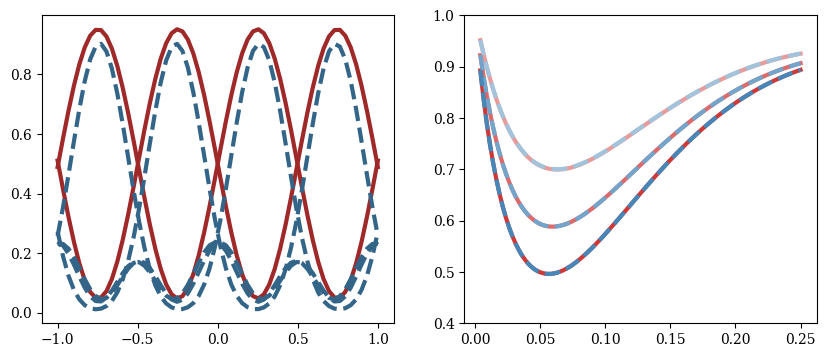

In [30]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax1, ax2 = axs
ax1.plot(vlist/l, p_array1, lw=3, color=red, label='TMSV',ls='-')
ax1.plot(vlist/l, p_array2, lw=3, color=blue, label='TMSV',ls='--')

MSEDs = [MSD_array1,MSD_array2, MSD_array3]
for i in range(3):
    MSE = np.sum(MSEDs[i], axis=1)
    print(MSE.shape,variance_list.shape)
    ax2.plot(variance_list/l, MSE/variance_list, lw=3, color=lighten_color(red,.4+.2*i), label='TMSV',ls='-')
MSEDs = [MSD_array4,MSD_array5, MSD_array6]
for i in range(3):
    MSE = np.sum(MSEDs[i], axis=1)
    ax2.plot(variance_list/l, MSE/variance_list, lw=3, color=lighten_color(blue,.4+.2*i), label='TMSV',ls='--')

ax2.set_ylim(.4,1)

## Appendix plot of qpath vs exact

In [ ]:
# runs for test purposes
# 200-202, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.15l
# 203-205, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0
# 206-208, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.25l

name1 = 'Data - qbits - params'+str(206)
results1 = np.load(path_QS_noise_results_qorppath+name1+'.npz')
print(results1.files)
vlist = results1['vlist']
p_array1 = results1['p_array']
MSD_array1 = results1['MSD_array']
variance_list = results1['variance_list']

name2 = 'Data - qbits - params'+str(207)
results2 = np.load(path_QS_noise_results_qorppath+name2+'.npz')
p_array2 = results2['p_array']
MSD_array2 = results2['MSD_array']

name3 = 'Data - qbits - params'+str(208)
results3 = np.load(path_QS_noise_results_qorppath+name3+'.npz')
p_array3 = results3['p_array']
MSD_array3 = results3['MSD_array']

name4 = 'Data - MSD - params'+str(206)
results4 = np.load(path_sbs_noise_results_exact+name4+'.npz')
vlist4 = results4['vlist']
MSD_array4 = results4['MSD_array']

name5 = 'Data - MSD - params'+str(207)
results5 = np.load(path_sbs_noise_results_exact+name5+'.npz')
MSD_array5 = results5['MSD_array']

name6 = 'Data - MSD - params'+str(208)
results6 = np.load(path_sbs_noise_results_exact+name6+'.npz')
MSD_array6 = results6['MSD_array']

MSE_qpath = [MSD_array1,MSD_array2, MSD_array3]
MSE_exact = [MSD_array4,MSD_array5, MSD_array6]

['MSD_array', 'MSD_array_displacement', 'variance_list', 'p_array', 'qf_array', 'pf_array', 'vlist', 'rho0_c', 'system_dict', 'rho_f_array']


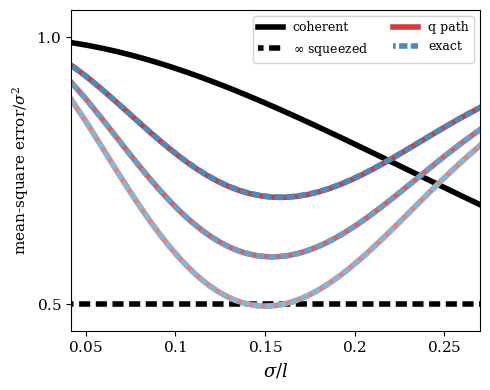

In [ ]:
def coherent_limit(v):
    return 1/(v+1)
def gaussian_limit(v):
    return v/2/v

def two_mode_squeezing_limit(v,r):
    return np.exp(-2*r)*v/(np.exp(-2*r)+v)
from scipy.optimize import fsolve
def solve_for_r(v, MSE):
    # Define the equation to solve
    def equation(r):
        return two_mode_squeezing_limit(v, r) - MSE
    # Use fsolve to find the root of the equation
    r_initial_guess = 0.5 # Initial guess for r
    r_solution = fsolve(equation, r_initial_guess)
    return r_solution[0]

def solve_for_r_coherent(v,MSE):
    # Define the equation to solve
    def equation(r):
        return coherent_limit(v, r) - MSE
    # Use fsolve to find the root of the equation
    r_initial_guess = 0.5 # Initial guess for r
    r_solution = fsolve(equation, r_initial_guess)
    return r_solution[0]

def minimum_r(stddev_range,MSE_array):
    r_array = np.zeros(len(MSE_array))
    for i in range(len(MSE_array)):
        MSE = MSE_array[i]
        v = stddev_range[i]
        r = solve_for_r(v, MSE)
        r_array[i] = r
    return r_array


Delta, k, steps, R = 0.3,0,60,4
cd = np.cosh(Delta**2)
q0_range = (l)*np.linspace(-1.0,1.0,steps)
stddev_range = np.sqrt(variance_list)

fig, ax = plt.subplots(1,1,figsize=(5,4))

line1, = ax.plot(stddev_range, coherent_limit(stddev_range**2),color='black',ls='-',lw=4,label='coherent')
line2, = ax.plot(stddev_range, gaussian_limit(stddev_range**2),color='black',ls=(1,(2,1)),lw=4,label=r'$\infty$ squeezed')
# path_sBs_bayesian = path_sBs+"data/bayesian/" 
lines = [line1,line2]

T_range = [4,2,1]
for i in range(3):
    T = T_range[i]
    MSE = MSE_qpath[i]
    MSE = np.sum(MSE, axis=1)
    
    shine = .5+.2*np.log(T)
    if i==0:
        line3, = ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,shine),lw=4,label='q path')
        lines.append(line3)
    else:
        ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,shine),lw=4)
    
for i in range(3):
    T = T_range[i]
    MSE = MSE_exact[i]
    MSE = np.sum(MSE, axis=1)
    
    shine = .5+.2*np.log(T)
    if i==0:
        line3, = ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(blue,shine),lw=4,label='exact',ls=(1, (1.5, .6)))
        lines.append(line3)
    else:
        ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(blue,shine),lw=4,ls=(1, (1.5, .7)))
    

handles = lines
labels = [h.get_label() for h in handles]

l = np.sqrt(2*np.pi)
ax.set_xlim(0.042*l,0.27*l)
ax.set_ylim(.45,1.05)
ax.set_xlabel(r'$\sigma/l$',fontsize=13)
ax.set_xticks([0.05*l,0.1*l,0.15*l,0.2*l,0.25*l])
ax.set_yticks([0.5,1])
xlabels = [r'$0.05$',r'$0.1$',r'$0.15$',r'$0.2$',r'$0.25$']
ylabels = [r'$0.5$',r'$1.0$']
ax.set_xticklabels(xlabels,fontsize=11)
ax.set_yticklabels(ylabels,fontsize=11)
ax.set_ylabel(r'$\text{mean-square error}/\sigma^2$',fontsize=11)
ax.legend(handles, labels,loc='upper right',fontsize=9,frameon=True,ncol=2)

plt.tight_layout()
name = 'appendix-qpath-vs-exact'
plt.savefig(path_figures+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)
plt.show()

## q and p performance Yale noise, appendix figure

In [ ]:
# runs for test purposes
# 200-202, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.15l
# 203-205, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0
# 206-208, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.25l
#151-152, delta = 0.3, 1.0 yale, 8 rounds, p0=0, q0=0 #use these results for backaction evading inputs
#139-142, delta = 0.3, 1 yale, 1,2,4,8 rounds, sensitivity with q0=0 p quadrature runs
#116-119, delta = 0.3,  yale, 1, 2, 4, 8 rounds, p0=0, sensitivity
#260-263, delta = 0.3, 1.0 yale, 1,2,4,8 rounds, q0=0 p sensitivity
#264-267, delta = 0.3, 1.0 yale, 1,2,4,8 rounds, q0=0

sensitivities_q, sensitivities_p = [], []
for idx in np.arange(116,120):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    vlist = results['vlist']
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_q.append(sensitivity)

for idx in np.arange(139,143):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    vlist = results['vlist']
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_p.append(sensitivity)

MSE_q, MSE_p = [], []
for idx in np.arange(203,206):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    stddev_range = np.sqrt(results['variance_list'])
    MSE = np.sum(results['MSD_array'], axis=1)
    MSE_q.append(MSE)

for idx in np.arange(264,267):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE = np.sum(results['MSD_array'], axis=1)
    MSE_p.append(MSE)

/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_46108/272772077.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(2,1, figsize=(4,4), gridspec_kw={'height_ratios': [1, 1]})


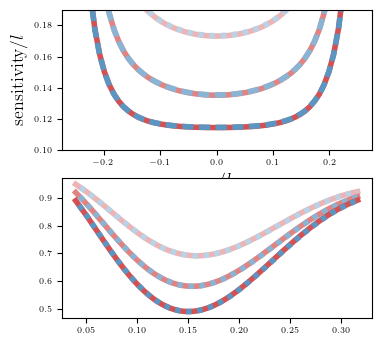

In [67]:
fig, axs = plt.subplots(2,1, figsize=(4,4), gridspec_kw={'height_ratios': [1, 1]})
ax, ax2 = axs

T_range = [1,2,4]
for i in range(3):
    T = T_range[i]
    shine = .3+.2*i
    if i==0:
        line1, = ax.plot(vlist/l, sensitivities_q[i]/l, color=lighten_color(red,shine), lw=4, label=r'$q$')
        line2, = ax.plot(vlist/l, sensitivities_p[i]/l, color=lighten_color(blue,shine), lw=4, label=r'$p$',ls=(1, (1, 1)))
    else:
        ax.plot(vlist/l, sensitivities_q[i]/l, color=lighten_color(red,shine), lw=4)
        ax.plot(vlist/l, sensitivities_p[i]/l, color=lighten_color(blue,shine), lw=4, ls=(1, (2, 1)))

for i in range(3):
    T = T_range[i]
    shine = .3+.2*i
    if i==0:
        line3, = ax2.plot(stddev_range/l, MSE_q[i]/stddev_range**2, color=lighten_color(red,shine), lw=4, label=r'$q$')
        line4, = ax2.plot(stddev_range/l, MSE_p[i]/stddev_range**2, color=lighten_color(blue,shine), lw=4, label=r'$p$',ls=(1, (1, 1)))
    else:
        ax2.plot(stddev_range/l, MSE_q[i]/stddev_range**2, color=lighten_color(red,shine), lw=4)
        ax2.plot(stddev_range/l, MSE_p[i]/stddev_range**2, color=lighten_color(blue,shine), lw=4, ls=(1, (1, 1)))

ax.set_xlabel(r'$q_0/l$', fontsize=13)
ax.set_ylabel(r'sensitivity/$l$', fontsize=13)
ax.set_ylim(.1,0.19)

dict_figure = {}
dict_figure['sensitivities_q'] = sensitivities_q
dict_figure['sensitivities_p'] = sensitivities_p
dict_figure['MSE_q'] = MSE_q
dict_figure['MSE_p'] = MSE_p
dict_figure['vlist'] = vlist
dict_figure['stddev_range'] = stddev_range
name = 'data-sensitivities-MSE-q-p'
np.savez(path_figures_data+name+'.npz', **dict_figure)

# initial/final density matrices

## simple check, plotting wigner

In [ ]:
name1 = 'Data - qbits - params'+str(11)
results1 = np.load(path_QS_noise_results_qorppath+name1+'.npz')
print(results1.files)
vlist = results1['vlist']
p_array1 = results1['p_array']
rho0_c1 = results1['rho0_c']
rho = qu.Qobj(rho0_c1)
print(rho.tr())

ideal_state_25 = qu.qload(path_sbs_noise+'/Input_states/sensor_state_delta-25-Nc140')
ideal_state_30 = qu.qload(path_sbs_noise+'/Input_states/sensor_state_delta-30-Nc140')


name2 = 'sensor_state_delta_25-Nc140-'+str(1.0)
results2 = np.load(path_QS_noise_results_states+name2+'.npz')
rho_f = results2['rho_f_array'][0]
rho_f = qu.Qobj(rho_f)
print('trace',rho_f.tr())
xvec = np.arange(-2*l,2*l,0.05)


name3 = 'coherent_sensor_state_delta_25-Nc140-'+str(1.0)
results3 = np.load(path_QS_noise_results_states+name3+'.npz')
rho_cf = results3['rho_f_array'][0]
rho_cf = qu.Qobj(rho_cf)

fidelity = qu.fidelity(rho_cf,rho_f)
print('fidelity',fidelity) #the same steady state
W = qu.wigner(rho_cf, xvec, xvec)
# print(type(rho))
# l = np.sqrt(2 * np.pi)
# Ndim = 140
# a_op = qu.destroy(Ndim)
# q_op = (a_op + a_op.dag())/np.sqrt(2)
# p_op = -1j*(a_op - a_op.dag())/np.sqrt(2)
# n_op = a_op.dag() * a_op
# Delta = 0.3
# envelope = (-Delta**2 * n_op).expm()
# T_q = (1j * l * q_op).expm()
# T_p = (1j * l * p_op).expm()
# T_qdelta = envelope * T_q * envelope.inv()
# T_pdelta = envelope * T_p * envelope.inv()
# print('Tq',(T_qdelta * rho_f).tr(),'Tp',(T_pdelta * rho_f).tr())

# name3 = 'Data - MSD - params'+str(5)# noisy Yale times 4
# results3 = np.load(path_sbs_noise_results+name3+'.npz')
# rho0_c3 = results3['rho0_c']
# rho = qu.Qobj(rho0_c3)
# print(rho.tr())
# xvec = np.arange(-2*l,2*l,0.05)
# W = qu.wigner(rho, xvec, xvec)

['MSD_array', 'MSD_array_displacement', 'variance_list', 'p_array', 'vlist', 'rho0_c', 'system_dict', 'rho_f_array']
(0.9999999999276806-8.530993675173063e-12j)
trace (0.9999983296656197-9.408003499838125e-12j)
fidelity 1.0000260871272013


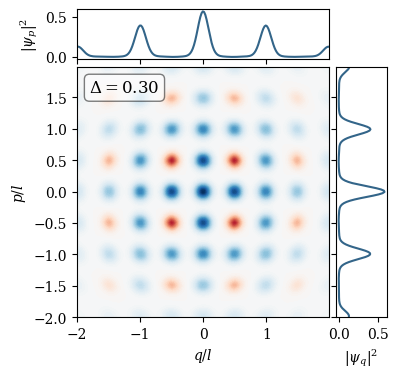

In [9]:
# Assuming W, xvec, and l are already defined
row_marginal = np.sum(W, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W.max(), W.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
contour = ax_main.contourf(xvec/l, xvec/l, W, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q/l$')
ax_main.set_ylabel(r'$p/l$')

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec/l, row_marginal, color=blue)
ax_row.set_ylabel(r'$|\psi_p|^2$')
ax_row.xaxis.set_tick_params(labelbottom=False)

# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec/l, color=blue)
ax_col.set_xlabel(r'$|\psi_q|^2$')
ax_col.yaxis.set_tick_params(labelleft=False)

# Add textbox with the value of Delta
Delta = 0.3
textstr = r'$\Delta = {0:.2f}$'.format(Delta)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)

plt.show()

## steady state fidelity between noisy preparation and ideal state

In [ ]:
delta_range = np.arange(0.25,0.41,.01)
ratios = [.25,.5,1.0,2.0]
fidelities = []
for ratio in tqdm(ratios):
    fidelity = []
    for delta in delta_range:
        name = 'coherent_sensor_state_delta_{0:.0f}-Nc140-'.format(delta*100)+str(ratio)
        results = np.load(path_QS_noise_results_states+name+'.npz')
        rho_cf = results['rho_f_array'][0]
        rho_cf = qu.Qobj(rho_cf)

        name2 = 'sensor_state_delta-{0:.0f}-Nc140'.format(delta*100)
        ideal_state = qu.qload(path_QS_noise_results_states+name2)
        fidelity.append(qu.fidelity(rho_cf,ideal_state))
    fidelities.append(np.array(fidelity))

100%|██████████| 4/4 [00:36<00:00,  9.25s/it]


4 16 4


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_38231/2593175411.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(5,4))


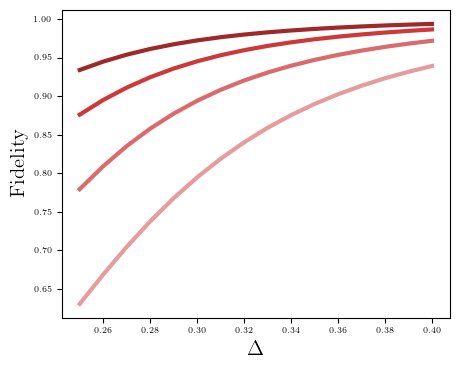

In [79]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

# name = 'appendix-fidelities-delta.npz'
# dict_fidelity = np.load(path_figures_data+name,allow_pickle=True)
# fidelities = dict_fidelity['fidelity']
for i in range(len(ratios)):
    shine = .4+.2*i
    ax.plot(delta_range,fidelities[i], lw=3, color=lighten_color(red,shine),ls='-')
ax.set_xlabel(r'$\Delta$',fontsize=15)
ax.set_ylabel(r'Fidelity',fontsize=15)

print(len(fidelities), len(delta_range), len(ratios))
dict_fidelity = {'fidelity': fidelities}
dict_fidelity['ratios'] = ratios
np.savez(path_figures_data+'appendix-fidelities-delta.npz', **dict_fidelity)


## fidelities each noise

### fidelities

In [22]:
delta_range = np.arange(0.25,0.41,.01)
ratios = np.arange(0.25,2.1,.25)
fidelities_T1c = []
fidelities_T2c = []
fidelities_T1q = []
fidelities_T2q = []
delta = 0.3
for ratio in tqdm(ratios):
    name = 'coherent_sensor_state_delta_{0:.0f}-Nc140-'.format(delta*100)+str(ratio)+'T1c'
    results = np.load(path_QS_noise_results_states+name+'.npz')
    rho_cf = results['rho_f_array'][0]
    rho_cf = qu.Qobj(rho_cf)

    #to do, get the plot with delta = 0.3 and the preparation fidelities. 
    #run the backaction on 32, all the T, M
    #then run the 4 rounds all noise from ideal state 
    #finally go for the backaction 

    name2 = 'sensor_state_delta-{0:.0f}-Nc140'.format(delta*100)
    ideal_state = qu.qload(path_QS_noise_results_states+name2)
    fidelities_T1c.append(qu.fidelity(rho_cf,ideal_state))

    name = 'coherent_sensor_state_delta_{0:.0f}-Nc140-'.format(delta*100)+str(ratio)+'T2c'
    results = np.load(path_QS_noise_results_states+name+'.npz')
    rho_cf = results['rho_f_array'][0]
    rho_cf = qu.Qobj(rho_cf)

    fidelities_T2c.append(qu.fidelity(rho_cf,ideal_state))

    name = 'coherent_sensor_state_delta_{0:.0f}-Nc140-'.format(delta*100)+str(ratio)+'T1q'
    results = np.load(path_QS_noise_results_states+name+'.npz')
    rho_cf = results['rho_f_array'][0]
    rho_cf = qu.Qobj(rho_cf)

    fidelities_T1q.append(qu.fidelity(rho_cf,ideal_state))

    name = 'coherent_sensor_state_delta_{0:.0f}-Nc140-'.format(delta*100)+str(ratio)+'T2q'
    results = np.load(path_QS_noise_results_states+name+'.npz')
    rho_cf = results['rho_f_array'][0]
    rho_cf = qu.Qobj(rho_cf)
    fidelities_T2q.append(qu.fidelity(rho_cf,ideal_state))


100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


[0.9994644880057014, 0.9997672597092176, 0.999866504878304, 0.9999113513217344, 0.999944252395702, 0.999960545954738, 0.9999756970736392, 0.9999793187407975]


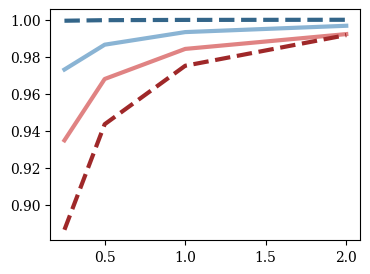

In [23]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

ratios = [.25,.5,1,2]
ax.plot(ratios, [fidelities_T1c[i]for i in [0,1,3,-1]], lw=3, color=lighten_color(red,.5), ls='-', label=r'$T_{1,c}$')
ax.plot(ratios, [fidelities_T2c[i]for i in [0,1,3,-1]], lw=3, color=lighten_color(red,1), ls='--', label=r'$T_{\phi,c}c$')
ax.plot(ratios, [fidelities_T1q[i]for i in [0,1,3,-1]], lw=3, color=lighten_color(blue,.5),  ls='-', label=r'$T_{1,q}$')
ax.plot(ratios, [fidelities_T2q[i]for i in [0,1,3,-1]], lw=3, color=lighten_color(blue,1),  ls='--', label=r'$T_{\phi,q}$')

dict_figure = {}
dict_figure['ratios'] = ratios
dict_figure['fidelities_T1c'] = fidelities_T1c
dict_figure['fidelities_T2c'] = fidelities_T2c
dict_figure['fidelities_T1q'] = fidelities_T1q
dict_figure['fidelities_T2q'] = fidelities_T2q
np.savez(path_QS_figures_data+'data-figure-fidelities-eachnoise.npz', **dict_figure)

print(fidelities_T2q)

### plotting wigner

In [ ]:
ideal_state_25 = qu.qload(path_sbs_noise+'/Input_states/sensor_state_delta-25-Nc140')
ideal_state_30 = qu.qload(path_sbs_noise+'/Input_states/sensor_state_delta-30-Nc140')

delta = 0.3
ratio = 1.0
name = 'coherent_sensor_state_delta_{0:.0f}-Nc140-'.format(delta*100)+str(ratio)+'T1q'
results = np.load(path_QS_noise_results_states+name+'.npz')
rho_f = results['rho_f_array'][0]
rho_f = qu.Qobj(rho_f)
print('trace',rho_f.tr())
xvec = np.arange(-2*l,2*l,0.05)

fidelity = qu.fidelity(ideal_state_30,rho_f)
print('fidelity',fidelity) #the same steady state
W = qu.wigner(rho_f, xvec, xvec)
# print(type(rho))


trace (0.9999999997908038-4.6560352471856173e-11j)
fidelity 0.9933181148161806


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_62977/3564695340.py:13: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax_main = fig.add_subplot(gs[1, 0])
/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_62977/3564695340.py:19: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_62977/3564695340.py:25: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)


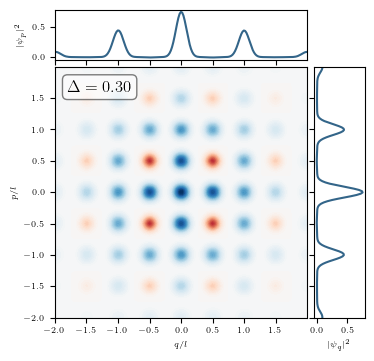

In [67]:
# Assuming W, xvec, and l are already defined
row_marginal = np.sum(W, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W.max(), W.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
contour = ax_main.contourf(xvec/l, xvec/l, W, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q/l$')
ax_main.set_ylabel(r'$p/l$')

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec/l, row_marginal, color=blue)
ax_row.set_ylabel(r'$|\psi_p|^2$')
ax_row.xaxis.set_tick_params(labelbottom=False)

# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec/l, color=blue)
ax_col.set_xlabel(r'$|\psi_q|^2$')
ax_col.yaxis.set_tick_params(labelleft=False)

# Add textbox with the value of Delta
Delta = 0.3
textstr = r'$\Delta = {0:.2f}$'.format(Delta)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)

plt.show()

# Metrology performance up to 4 rounds each noise

In [12]:
#now on q-p bitstrings, separately 
#1-4, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T1 cavity
#5-8, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T2 cavity
#9-12, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T1 qubit
#13-16, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T2 qubit
#17-20, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T1 cavity sensitivity
#21-24, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T2 cavity sensitivity
#25-28, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T1 qubit sensitivity
#29-32, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T2 qubit sensitivity

MSE_arrays_T1c = []
sensitivities_T1c = []
vlist = np.linspace(-.25*l, .25*l, 60)
for idx in tqdm(np.arange(17,21)):
    name = 'Data - qbits - params'+str(idx)+'-eachnoise'
    results = np.load(path_QS_noise_results_eachnoise+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    MSE_arrays_T1c.append(MSE)
    sensitivities_T1c.append(sensitivity)

MSE_arrays_T2c = []
sensitivities_T2c = []
for idx in tqdm(np.arange(21,25)):
    name = 'Data - qbits - params'+str(idx)+'-eachnoise'
    results = np.load(path_QS_noise_results_eachnoise+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    MSE_arrays_T2c.append(MSE)
    sensitivities_T2c.append(sensitivity)

MSE_arrays_T1q = []
sensitivities_T1q = []
for idx in tqdm(np.arange(25,29)):
    name = 'Data - qbits - params'+str(idx)+'-eachnoise'
    results = np.load(path_QS_noise_results_eachnoise+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    MSE_arrays_T1q.append(MSE)
    sensitivities_T1q.append(sensitivity)

MSE_arrays_T2q = []
sensitivities_T2q = []
for idx in tqdm(np.arange(29,33)):
    name = 'Data - qbits - params'+str(idx)+'-eachnoise'
    results = np.load(path_QS_noise_results_eachnoise+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    MSE_arrays_T2q.append(MSE)
    sensitivities_T2q.append(sensitivity)

100%|██████████| 4/4 [00:00<00:00, 43.25it/s]


(0.0, 0.25)

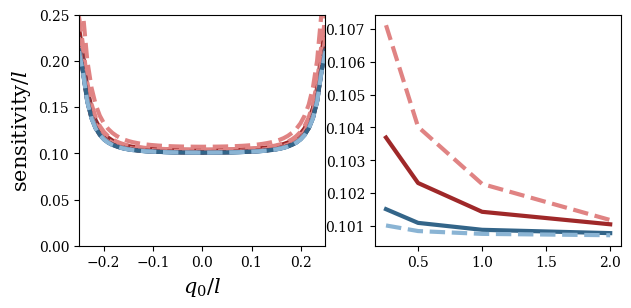

In [15]:
fig, axs = plt.subplots(1,2, figsize=(7,3))
ax, ax2 = axs
for i in range(4):
    ax.plot(vlist/l, sensitivities_T1c[i]/l, lw=3, color=lighten_color(red,1), ls='-', label=r'$T_{1,c}$')
    ax.plot(vlist/l, sensitivities_T2c[i]/l, lw=3, color=lighten_color(red,.5), ls='--', label=r'$T_{\phi,c}$')
    ax.plot(vlist/l, sensitivities_T1q[i]/l, lw=3, color=lighten_color(blue,1),  ls='-', label=r'$T_{1,q}$')
    ax.plot(vlist/l, sensitivities_T2q[i]/l, lw=3, color=lighten_color(blue,.5),  ls='--', label=r'$T_{\phi,q}$')

ratios = [.25,.5,1.0,2.0]
min_s_T1c = []
min_s_T2c = []
min_s_T1q = []
min_s_T2q = []
for i in range(4):
    min_s_T1c.append(np.min(sensitivities_T1c[i]))
    min_s_T2c.append(np.min(sensitivities_T2c[i]))
    min_s_T1q.append(np.min(sensitivities_T1q[i]))
    min_s_T2q.append(np.min(sensitivities_T2q[i]))

ax2.plot(ratios, min_s_T1c/l, lw=3, color=lighten_color(red,1), ls='-', label=r'$T_{1,c}$')
ax2.plot(ratios, min_s_T2c/l, lw=3, color=lighten_color(red,.5), ls='--', label=r'$T_{\phi,c}$')
ax2.plot(ratios, min_s_T1q/l, lw=3, color=lighten_color(blue,1),  ls='-', label=r'$T_{1,q}$')
ax2.plot(ratios, min_s_T2q/l, lw=3, color=lighten_color(blue,.5),  ls='--', label=r'$T_{\phi,q}$')

dict_figure = {}
dict_figure['ratios'] = ratios
dict_figure['min_s_T1c'] = min_s_T1c
dict_figure['min_s_T2c'] = min_s_T2c
dict_figure['min_s_T1q'] = min_s_T1q
dict_figure['min_s_T2q'] = min_s_T2q
dict_figure['sensitivities_T1c'] = sensitivities_T1c
dict_figure['sensitivities_T2c'] = sensitivities_T2c
dict_figure['sensitivities_T1q'] = sensitivities_T1q
dict_figure['sensitivities_T2q'] = sensitivities_T2q

name = 'data-figure-sensitivities-eachnoise.npz'
np.savez(path_QS_figures_data+name, **dict_figure)

ax.set_xlabel(r'$q_0/l$',fontsize=15)
ax.set_ylabel(r'sensitivity/$l$',fontsize=15)
ax.set_xlim(-.25,.25)
ax.set_ylim(0,.25)
# ax2.set_ylim(0,.25)

# Isolating noise source, state or rounds

In [19]:
#running noise up to 4 bits per quadrature
#268-270, delta = 0.3, 0.25 yale, 1,2,4 rounds, q0=0 sensitivity
#271-273, delta = 0.3, 0.25 yale, 1,2,4 rounds, p0=0 sensitivity
#274-277, delta = 0.25, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #ideal state, noisy metrology
#278-281, delta = 0.25, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, q0=0 sensitivity #noisy state, ideal metrology
#282-285, delta = 0.3, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #ideal state, noisy metrology
#286-289, delta = 0.3, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, q0=0 sensitivity #noisy state, ideal metrology
#290-293, delta = 0.35, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #ideal state, noisy metrology
#294-297, delta = 0.35, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, q0=0 sensitivity #noisy state, ideal metrology 
#298-301, delta = 0.4, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #ideal state, noisy metrology
#302-305, delta = 0.4, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, q0=0 sensitivity #noisy state, ideal metrology


sensitivities_25_noisystate = []
vlist = np.linspace(-.25*l, .25*l, 60)
for idx in tqdm(np.arange(278,282)):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_25_noisystate.append(sensitivity)

sensitivities_30_noisystate = []
for idx in tqdm(np.arange(286,290)):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_30_noisystate.append(sensitivity)

sensitivities_35_noisystate = []
for idx in tqdm(np.arange(294,298)):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_35_noisystate.append(sensitivity)

sensitivities_40_noisystate = []
for idx in tqdm(np.arange(302,306)):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_40_noisystate.append(sensitivity)

sensitivities_25_idealstate = []
for idx in tqdm(np.arange(274,278)):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_25_idealstate.append(sensitivity)

sensitivities_30_idealstate = []
for idx in tqdm(np.arange(282,286)):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_30_idealstate.append(sensitivity)

sensitivities_35_idealstate = []
for idx in tqdm(np.arange(290,294)):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_35_idealstate.append(sensitivity)

sensitivities_40_idealstate = []
for idx in tqdm(np.arange(298,302)):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    sensitivities_40_idealstate.append(sensitivity)

100%|██████████| 4/4 [00:00<00:00, 67.43it/s]


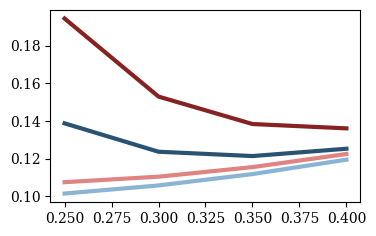

In [20]:
fig, ax = plt.subplots(1,1, figsize=(4,2.5))

sensitivities_025_noisystate, sensitivities_050_noisystate, sensitivities_1_noisystate, sensitivities_2_noisystate = [], [], [], []
sensitivities_025_idealstate, sensitivities_050_idealstate, sensitivities_1_idealstate, sensitivities_2_idealstate = [], [], [], []
all_delta_sensitivities = [sensitivities_25_noisystate, sensitivities_30_noisystate, sensitivities_35_noisystate, sensitivities_40_noisystate]
all_delta_sensitivities_ideal = [sensitivities_25_idealstate, sensitivities_30_idealstate, sensitivities_35_idealstate, sensitivities_40_idealstate]
for i in range(4):
    sensitivities_025_noisystate.append(np.min(all_delta_sensitivities[i][0]))
    sensitivities_050_noisystate.append(np.min(all_delta_sensitivities[i][1]))
    sensitivities_1_noisystate.append(np.min(all_delta_sensitivities[i][2]))
    sensitivities_2_noisystate.append(np.min(all_delta_sensitivities[i][3]))
    sensitivities_025_idealstate.append(np.min(all_delta_sensitivities_ideal[i][0]))
    sensitivities_050_idealstate.append(np.min(all_delta_sensitivities_ideal[i][1]))
    sensitivities_1_idealstate.append(np.min(all_delta_sensitivities_ideal[i][2]))
    sensitivities_2_idealstate.append(np.min(all_delta_sensitivities_ideal[i][3]))

    
Delta_range = [0.25,0.3,.35,0.4]

ax.plot(Delta_range, sensitivities_025_noisystate/l, lw=3, color=lighten_color(red,1.1), ls='-', label=r'$\Delta = 0.25$')
ax.plot(Delta_range, sensitivities_050_noisystate/l, lw=3, color=lighten_color(blue,1.1), ls='-', label=r'$\Delta = 0.30$')
# ax.plot(Delta_range, sensitivities_1_noisystate/l, lw=3, color=lighten_color(blue,1), ls='-', label=r'$\Delta = 0.50$')
# ax.plot(Delta_range, sensitivities_2_noisystate/l, lw=3, color=lighten_color(light_blue,1), ls='-', label=r'$\Delta = 1.00$')

ax.plot(Delta_range, sensitivities_025_idealstate/l, lw=3, color=lighten_color(red,.5), ls='-', label=r'$\Delta = 0.25$ ideal')
ax.plot(Delta_range, sensitivities_050_idealstate/l, lw=3, color=lighten_color(blue,.5), ls='-', label=r'$\Delta = 0.30$ ideal')
# ax.plot(Delta_range, sensitivities_1_idealstate/l, lw=3, color=lighten_color(blue,.5), ls='--', label=r'$\Delta = 0.50$ ideal')
# ax.plot(Delta_range, sensitivities_2_idealstate/l, lw=3, color=lighten_color(light_blue,.5), ls='--', label=r'$\Delta = 1.00$ ideal')

dict_figure = {}
dict_figure['Delta_range'] = Delta_range
dict_figure['sensitivities_025_noisystate'] = sensitivities_025_noisystate
dict_figure['sensitivities_050_noisystate'] = sensitivities_050_noisystate
dict_figure['sensitivities_1_noisystate'] = sensitivities_1_noisystate
dict_figure['sensitivities_2_noisystate'] = sensitivities_2_noisystate
dict_figure['sensitivities_025_idealstate'] = sensitivities_025_idealstate
dict_figure['sensitivities_050_idealstate'] = sensitivities_050_idealstate
dict_figure['sensitivities_1_idealstate'] = sensitivities_1_idealstate
dict_figure['sensitivities_2_idealstate'] = sensitivities_2_idealstate
name = 'data-figure-sensitivities-state-vs-metrology.npz'
np.savez(path_QS_figures_data+name, **dict_figure)

# creating yaml files

In [32]:
params_list = [
    {
        'dimensions':{ 
            'qubit': 2,
            'cavity': 150,
        },
        'state_params':{
            'delta' : 0.25,
            'l' : np.sqrt(2 * np.pi),
        },
        'decays':{
        'qubit_T1': 280, # in us
        'qubit_T2': 240, # in us
        'cavity_T1': 610, # in us
        'cavity_T2': 980, # in us
        },
        'simulations':{
        'r': 1,
        'v_lim': 1,
        't_CD_B': 3.594, # in us
        'kerr': -2*np.pi*4.8*10e-6, # in MHz
        'n_v': 48,
        'p_0': 0.0,
        'n_jobs': 24,
        },
    }
]

In [ ]:
#new definitions of the parameters, still to be run, keep the old ones for now. 
#1-4, delta=0.3, noiseless, 1,2,4,5 rounds, p0=0
#5-8, delta=0.3, yale, 1,2,4,5 rounds, p0=0
#9-12, delta=0.3, yale*0.5, 1,2,4,5 rounds, p0=0
#13-16, delta=0.3, yale T1*1.25, 1,2,4,5 rounds, p0=0
#44-47, delta=0.3, yale T1*0.75, 1,2,4,5 rounds, p0=0
#48-51, delta=0.3, yale T1*1.5, 1,2,4,5 rounds, p0=0

#then repeat for delta=0.25
#17-20, delta=0.25, noiseless, 1,2,4,5 rounds, p0=0
#21-24, delta=0.25, yale, 1,2,4,5 rounds, p0=0
#25-28, delta=0.25, yale*0.5, 1,2,4,5 rounds, p0=0
#29-32, delta=0.25, yale*1.5, 1,2,4,5 rounds, p0=0
#52-54, delta=0.25, yale qubit *1.5, 1,2,4 rounds, p0=0

#then repeat for delta=0.2
#61-64, delta=0.2, noiseless, 1,2,4,5 rounds, p0=0
#65-68, delta=0.2, yale, 1,2,4,5 rounds, p0=0
#69-72, delta=0.2, yale*0.5, 1,2,4,5 rounds, p0=0
#73-76, delta=0.2, yale*1.25, 1,2,4,5 rounds, p0=0
#77-80, delta=0.2, yale*1.5, 1,2,4 rounds, p0=0

#definitions of the parameters in steady state
#1-4, delta = 0.3, (1,.5,.25,.1 yale), 100 rounds, q0 = p0 = 0
#10-26, delta in (0.25,0.4), yale, 100 rounds, q0 = p0 = 0
#28-43, delta in (0.25,0.4), 0.5 yale, 100 rounds, q0 = p0 = 0
#44-59, delta in (0.25,0.4), 0.75 yale, 100 rounds, q0 = p0 = 0
#60-75, delta in (0.25,0.4), 1.5 yale, 100 rounds, q0 = p0 = 0
#76-91, delta in (0.25,0.4), 2.0 yale, 100 rounds, q0 = p0 = 0
#92-107, delta in (0.25,0.4), 0.25 yale, 100 rounds, q0 = p0 = 0

#definitions of the parameters (q bits)
#1-3, delta = 0.3, yale, 1, 2, 8 rounds, p0=0
#4-6, delta = 0.3, yale, 1, 2, 8 rounds, p0=l/4
#7-9, delta = 0.3, yale, 1, 2, 8 rounds, q0=0
#10-12, delta = 0.3, yale, 1, 2, 8 rounds, q0=l/4
#13-14, delta = 0.3, yale, 4 rounds, q0=0, p0=0
#15-16, delta = 0.3, yale, 4 rounds, q0=l/4, p0=l/4
#17-19, delta = 0.3, 0.5 yale, 1,2,4 rounds, p0=l/4
#20-22, delta = 0.3, 0.5 yale, 1,2,4 rounds, q0=l/4
#23-24, delta = 0.3, 1.0, 0.5 yale, 8 rounds, p0=0
#25-27, delta = 0.25, yale, 1, 2, 4 rounds, p0=0
#28-30, delta = 0.25, 0.5 yale, 1, 2, 4 rounds, p0=0
#31-46, delta in (.25,.4,.01), yale, 1, round p0=0
#48-63, delta in (.25,.4,.01), 0.5 yale, 1, round p0=0
#64-79, delta in (.25,.4,.01), 0.75 yale, 1, round p0=0
#80-95, delta in (.25,.4,.01), 1.5 yale, 1, round p0=0
#96-99, delta = 0.34, yale, 1, 2, 4, 8 rounds, p0=0
#100-103, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, p0=0
#104-107, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, p0=0
#108-111, delta = 0.34, 0.75 yale, 1, 2, 4, 8 rounds, p0=0
#112-115, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, p0=0
#116-119, delta = 0.3,  yale, 1, 2, 4, 8 rounds, p0=0, sensitivity
#120-123, delta = 0.3, 0.5 yale, 1, 2, 4, 8 rounds, sensitivity
#124-127, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, sensitivity
#128-131, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, sensitivity
#132-135, delta = 0.3, 0.25 yale, 1, 2, 4, 8 rounds, sensitivity
#136-138, delta = 0.3, .5,1,1.5 yale, 4 rounds, sensitivity with p0=l/4
#139-142, delta = 0.3, 1 yale, 1,2,4,8 rounds, sensitivity with q0=0 p quadrature runs
#143-146, delta = 0.3, 2.0 yale, 1, 2, 4, 8 rounds, sensitivity with p0=l/4
#147-150, delta = 0.3, 2.0 yale, 1, 2, 4, 8 rounds, p0=0
#151-152, delta = 0.3, 1.0 yale, 8 rounds, p0=0, q0=0 #use these results for backaction evading inputs
#153, delta = 0.3, 1.0 yale, 4 rounds, q0 = 0
#154-157, delta = 0.3, 0.25 yale, 1,2,4,8 rounds, p0 = 0
#158-161, delta = 0.3, 0.25 yale, 1,2,4,8 rounds, sensitivity

# for test purposes
# 200-202, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.15l
# 203-205, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0
# 206-208, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.25l
# 209-211, delta = 0.3, 1.0 yale, 1,2,4 rounds, q0=0

#forgotten 2.0 1 round
#212-227, delta in (.25,.4,.01), 2.0 yale, 1, round p0=0
#228-243, delta in (.25,.4,.01), 0.25 yale, 1, round p0=0,

#sensitivites with 4 deltas, 4 noise levels, and 4 rounds
#244-247, delta = 0.25, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity
#248-251, delta = 0.30, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity
#252-255, delta = 0.35, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity
#256-259, delta = 0.40, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity

#confirming q and p sensitivities
#260-263, delta = 0.3, 1.0 yale, 1,2,4,8 rounds, q0=0 p sensitivity
#running noise up to 4 bits per quadrature
#268-270, delta = 0.3, 0.25 yale, 1,2,4 rounds, q0=0 sensitivity
#271-273, delta = 0.3, 0.25 yale, 1,2,4 rounds, p0=0 sensitivity
# start from ideal state and have noisy metrology
#274-277, delta = 0.25, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #ideal state, noisy metrology
#278-281, delta = 0.25, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, q0=0 sensitivity #noisy state, ideal metrology
#282-285, delta = 0.3, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #ideal state, noisy metrology
#286-289, delta = 0.3, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, q0=0 sensitivity #noisy state, ideal metrology
#290-293, delta = 0.35, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #ideal state, noisy metrology
#294-297, delta = 0.35, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, q0=0 sensitivity #noisy state, ideal metrology 
#298-301, delta = 0.4, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, p0=0 sensitivity #ideal state, noisy metrology #runned up to here
#302-305, delta = 0.4, 0.25, 0.5, 1.0, 2.0 yale, 4 rounds, q0=0 sensitivity #noisy state, ideal metrology

# sensitivity with p0=l/4
#306-308, delta = 0.3, 0.25 yale, 1,2,4 rounds, p0=0 sensitivity
#309-311, delta = 0.3, 0.25 yale, 1,2,4 rounds, q0=0 sensitivity


# isolating each type of noise. First on state preparation. 
#108-111, 0.25,.5,1.0 2.0 yale yale, 100 rounds, q0 = p0 = 0 T1 cavity
#112-115, 0.25,.5,1.0 2.0 yale yale, 100 rounds, q0 = p0 = 0 T2 cavity
#116-119, 0.25,.5,1.0 2.0 yale yale, 100 rounds, q0 = p0 = 0 T1 qubit
#120-123, 0.25,.5,1.0 2.0 yale yale, 100 rounds, q0 = p0 = 0 T2 qubit
#124-131, arange(.25,2.1,.25) yale, 100 rounds, q0 = p0, 0 T1 cavity, delta = 0.3
#132-139, arange(.25,2.1,.25) yale, 100 rounds, q0 = p0, 0 T2 cavity, delta = 0.3
#140-147, arange(.25,2.1,.25) yale, 100 rounds, q0 = p0, 0 T1 qubit, delta = 0.3
#148-155, arange(.25,2.1,.25) yale, 100 rounds, q0 = p0, 0 T2 qubit, delta = 0.3


#now on q-p bitstrings, separately 
#1-4, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T1 cavity
#5-8, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T2 cavity
#9-12, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T1 qubit
#13-16, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T2 qubit
#17-20, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T1 cavity sensitivity
#21-24, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T2 cavity sensitivity
#25-28, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T1 qubit sensitivity
#29-32, delta = 0.3, 0.25, .5, 1.0, 2.0 yale, 4 rounds, p0=0 T2 qubit sensitivity

#redo the steady states T2s with the right parameters. 

#to do now write the function to run this for each delta. Objective is to compare steady state fidelities for each noise type. done
#finally run up to 4 rounds with delta 0.3, for each noise, 0.25,0.5,1.0,2.0 yale and compare the performance. 
#also, run the 1 round with 2.0 yale noise and full delta range. done. 
#finally, with yale noise, and its best delta, run the backacion evading with N=8, T=8, M=8, 

def create_yaml_params_file(params, filename):
    with open(filename, 'w') as file:
        yaml.dump(params, file, default_flow_style=False)

path_create = path_sbs_noise_params_qorppaths
# path_create = path_sbs_noise_params
# path_create = path_sbs_noise_params_steady
# path_create = path_sbs_noise_params_exact
# path_create = path_sbs_noise_params_eachnoise

path_to_copy = path_sbs_noise_params_qorppaths + 'params116.yaml'

delta_range = np.arange(0.25,0.41,.01)
ratio_range = np.arange(.25,2.1,.25)

eachnoise_index_dict = {'T1c':list(np.arange(1,5))+list(np.arange(17,21)),
                        'T2c':list(np.arange(5,9))+list(np.arange(21,25)),
                        'T1q':list(np.arange(9,13))+list(np.arange(25,29)),
                        'T2q':list(np.arange(13,17))+list(np.arange(29,33)),
}

steady_states_eachnoise_dict = {'T1c':np.arange(124,132,1), 
                                'T2c':np.arange(132,140,1), 
                                'T1q':np.arange(140,148,1), 
                                'T2q':np.arange(148,156,1)
}

for i in range(306,312):
    filename = 'params{}.yaml'.format(i)
    # ratio = ratio_range[i-148]
    # path_to_copy = path_create + filename
    yaml_to_copy = yaml.safe_load(Path(path_to_copy).read_text())
    new_yaml = yaml_to_copy.copy()
    # new_yaml['simulations']['n_jobs'] = 20
    # new_yaml['simulations']['v_lim'] = eval(str(0.25))
    # new_yaml['simulations']['r'] = eval(str(4))
    ratio = 0.25 
    # print(i,ratio)
    # ratio = 1.0
    new_yaml['decays']['ratio'] = eval(str(ratio))
    # if i in eachnoise_index_dict['T1c']:
    #     new_yaml['decays']['cavity_T1'] = eval(str(yaml_to_copy['decays']['cavity_T1'] * ratio))
    # if i in steady_states_eachnoise_dict['T2c']:
    #     new_yaml['decays']['cavity_T2'] = eval(str(4981 * ratio))
    #     new_yaml['decays']['cavity_T1'] = eval(str(10000))
    # elif i in steady_states_eachnoise_dict['T2q']:
    #     new_yaml['decays']['qubit_T2'] = eval(str(420 * ratio))
    #     new_yaml['decays']['qubit_T1'] = eval(str(10000))
    # elif i in eachnoise_index_dict['T1q']:
    #     new_yaml['decays']['qubit_T1'] = eval(str(yaml_to_copy['decays']['qubit_T1'] * ratio))
    # elif i in eachnoise_index_dict['T2q']:
    #     new_yaml['decays']['qubit_T2'] = eval(str(yaml_to_copy['decays']['qubit_T2'] * ratio))
    # new_yaml['simulations']['n_v'] = eval(str(1))
    # new_yaml['state_params']['delta'] = eval(str(0.4))
    new_yaml['decays']['cavity_T2'] = eval(str(yaml_to_copy['decays']['cavity_T2'] * ratio))
    new_yaml['decays']['cavity_T1'] = eval(str(yaml_to_copy['decays']['cavity_T1'] * ratio))
    new_yaml['decays']['qubit_T2'] = eval(str(yaml_to_copy['decays']['qubit_T2'] * ratio))
    new_yaml['decays']['qubit_T1'] = eval(str(yaml_to_copy['decays']['qubit_T1'] * ratio))
    create_yaml_params_file(new_yaml, path_create + filename)
    # create_yaml_params_file(params_list[0], path_create + filename)
    # shutil.copy(path_to_copy, path_create + filename)

# figuring out T2 and T1

In [ ]:
T1c = 610
T2c = 980
T1q = 280
T2q = 240
Tcphi = 1/T2c - 1/2/T1c
Tqphi = 1/T2q - 1/2/T1q
print('Tcphi',Tcphi, 1/Tcphi)
print('Tqphi',Tqphi, 1/Tqphi)
#so for each noise, we start with T2c = 4981, T2q = 420

Tcphi 0.00020073603211776523 4981.666666666664
Tqphi 0.002380952380952381 419.99999999999994
